### Modelling distortions in narratives

An (overfitted) transformer-based model such as GPT-2 can memorise its training data. Here we explore distortions in the resulting model when trained on narratives, comparing the results to Raykov et al. (2023).

Local:

In [ ]:
!pip install simpletransformers torch

Colab:

In [10]:
!pip install transformers torch simpletransformers evaluate accelerate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━

In [2]:
import sys
sys.path.append('../scripts')

import pandas as pd
from random import shuffle
import random
from story_utils import *
import pickle
import matplotlib.pyplot as plt
import numpy as np
import gc
import torch
import glob
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import t

random.seed(1)

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

class GPT:

    def __init__(self, base_model):
        self.tokenizer = GPT2Tokenizer.from_pretrained(base_model)
        self.model = GPT2LMHeadModel.from_pretrained(base_model)

    def continue_input(self, input_sequence, max_length=200, num_return_sequences=1, no_repeat_ngram_size=10,
                       do_sample=False, temperature=0, num_beams=1):

        input_ids = self.tokenizer.encode(input_sequence, return_tensors='pt')
        max_length = len(input_ids[0]) + 100

        # Generate text
        output = self.model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=do_sample,
        )

        # Decode the output
        sequence = output[0].tolist()
        text = self.tokenizer.decode(sequence)
        return text

In [3]:
def prepare_data(num_typical=100, num_char=50, num_variants=20):
    stories = get_stories()
    shuffle(stories)
    lengths = [len(s) for s in stories]
    mean_len = np.mean(lengths)
    mean_len = int(mean_len)
    print(mean_len)

    typical = stories[:num_typical]
    lengthened = []
    shortened = []
    for s in stories[num_typical:]:
        if len(s) < mean_len:
            delta = mean_len - len(s)
            # increase length up to average
            if delta > 100:
                new_s = s + get_random_sentence(stories)[0:delta]
                lengthened.append(new_s)
        if len(s) > mean_len:
            # decrease length down to average
            delta = len(s) - mean_len
            if delta > 100:
                new_s = s[0:mean_len]
                shortened.append(new_s)

    stories = [s + ' The end.' for s in stories]
    shortened = [s + ' The end.' for s in shortened]
    lengthened = [s + ' The end.' for s in lengthened]
    return stories[:num_typical], shortened[:num_variants], lengthened[:num_variants]

In [4]:
def compute_length_difference(stories):
    """
    Computes the length difference between input and output for a given list of stories.
    """
    differences = []
    for story in stories:
        input_length = len(story[0])
        output_length = len(story[1])
        difference = output_length - input_length
        differences.append(difference)
        print(difference)
    return sum(differences) / len(differences)


In [5]:
def test_model(save_name, typical, atypical_short, atypical_long):

    model = GPT(base_model='outputs_stories')

    results_dict = {}
    results_dict['typical'] = []
    results_dict['atypical_short'] = []
    results_dict['atypical_long'] = []

    for s in typical[0:len(atypical_short)]:
        start = " ".join(s.split()[0:10])
        gen = model.continue_input(start)
        if 'The end.' in gen:
            gen = gen[0:gen.index('The end.')+8]
            print(f"START: \n{start}")
            print(f"GENERATED: \n{gen}")
            print(f"TRUE: \n{s}")
            results_dict['typical'].append([s, gen])

    for s in atypical_short:
        start = " ".join(s.split()[0:10])
        gen = model.continue_input(start)
        if 'The end.' in gen:
            gen = gen[0:gen.index('The end.')+8]
            print(f"START: \n{start}")
            print(f"GENERATED: \n{gen}")
            print(f"TRUE: \n{s}")
            results_dict['atypical_short'].append([s, gen])

    for s in atypical_long:
        start = " ".join(s.split()[0:10])
        gen = model.continue_input(start)
        if 'The end.' in gen:
            gen = gen[0:gen.index('The end.')+8]
            print(f"START: \n{start}")
            print(f"GENERATED: \n{gen}")
            print(f"TRUE: \n{s}")
            results_dict['atypical_long'].append([s, gen])


    # Calculate the average length difference for each category
    typical_difference = compute_length_difference(results_dict['typical'])
    atypical_short_difference = compute_length_difference(results_dict['atypical_short'])
    atypical_long_difference = compute_length_difference(results_dict['atypical_long'])

    # Plotting the results
    categories = ['Atypical Short', 'Typical', 'Atypical Long']
    differences = [atypical_short_difference, typical_difference, atypical_long_difference]

    plt.figure()
    plt.bar(categories, differences)
    plt.xlabel('Story Category')
    plt.ylabel('Average Length Difference (Output - Input)')
    plt.title('Length Difference by Story Category')
    plt.axhline(y=0, color='black')
    plt.savefig(save_name)
    plt.show()

    with open(save_name + '.pkl', 'wb') as handle:
        pickle.dump(results_dict, handle)

    return results_dict

In [6]:
!rm -rf plots
!mkdir plots

In [7]:
!rm -rf outputs_stories
!mkdir outputs_stories

In [4]:
import os
os.environ['WANDB_MODE'] = 'disabled'

222
2024-10-21 12:15:21.566984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:15:21.588359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:15:21.594897: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:15:22.809155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/21/2024 12:15:25 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
10/21/2024 12:15:25 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
We drove through miles of mountains to our destination. We
GENERATED: 
We drove through miles of mountains to our destination. We were halfway through the mountains when we came to a small town. The townspeople were very thankful that we were not in Boston. We were headed there to celebrate. The end.
TRUE: 
We drove through miles of mountains to our destination. We were in the Ozarks. The mountains became very steep and frightening. The air pressure was uncomfortable in my ears. We finally made it to our destination safely. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
On Tuesday we thought we heard thunder. We heard loud
GENERATED: 
On Tuesday we thought we heard thunder. We heard loud crashing noises, and a woman was lifting a ladder. The woman was carrying a big stick. The woman was going to use it to discipline those who broke the rules. The end.
TRUE: 
On Tuesday we thought we heard thunder. We heard loud crashing noises, but it was clear. My wife went downstairs to the gym in the building. Some people were lifting weights and throwing them down. The concierge asked them to stop dropping the weights. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jenny got a job at an office building. She put
GENERATED: 
Jenny got a job at an office building. She put a plant on her new desk on her first day. Jenny ate lunch in the cafeteria with her co-workers. She went back to her desk after lunch to work some more. Jenny found her car in the parking lot at the end of the day. The end.
TRUE: 
Jenny got a job at an office building. She put a plant on her new desk on her first day. Jenny ate lunch in the cafeteria with her co-workers. She went back to her desk after lunch to work some more. Jenny found her car in the parking lot at the end of the day. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
We live by an ice pond. In 1999 the state
GENERATED: 
We live by an ice pond. In 1999 the state drained the pond to remove sediment. They found a number of ancient ploughshare ploughsharers. The ploughsharers were buried in the ground. The ploughsharers were not very popular with the kids. The kids dug a big hole and buried it. They were going to uncover it when they were graduating. The end.
TRUE: 
We live by an ice pond. In 1999 the state drained the pond to remove sediment. They discovered a nineteenth century ploughshare. Apparently there used to be a farm nearby. The ploughshare is now on display in the neighborhood museum. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man put poison on the weeds. The weeds did
GENERATED: 
The man put poison on the weeds. The weeds did not die. The man tried another poison. The weeds did die. The man tried another poison. The man tried another poison. The man was so angry that he threw a smoke alarm. The end.
TRUE: 
The man put poison on the weeds. The weeds did not die. The man tried another poison. Some of the weeds died. The man decided to pull the rest of the weeds by hand. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Allie wanted a new kitten. So she went to the
GENERATED: 
Allie wanted a new kitten. So she went to the local shelter. There, she picked up a tabby cat. She named it Tiny Tammy. The end.
TRUE: 
Allie wanted a new kitten. So she went to the local shelter. She picked up a tabby cat. Allie was so happy to have a cat. She couldn't believe she was an owner now. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Samuel took one look at the woman. He knew he
GENERATED: 
Samuel took one look at the woman. He knew he recognized her from somewhere. She was his old teacher. He had been very scared of her in school. Now she was just a weak, old woman. The end.
TRUE: 
Samuel took one look at the woman. He knew he recognized her from somewhere. She was his old teacher. He had been very scared of her in school. But now she was just a weak, old woman. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Isaac got a camera for his birthday. And he was
GENERATED: 
Isaac got a camera for his birthday. And he was completely obsessed with it. He took pictures every day to take pictures with. And he loved them all. The end.
TRUE: 
Isaac got a camera for his birthday. And he was completely obsessed with it. Everyday he went outside to take pictures. And he eventually took photography courses in college. Isaac was happy when he finally became a professional photographer. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jim wanted to decorate his house for Christmas. He started
GENERATED: 
Jim wanted to decorate his house for Christmas. He started stringing colored lights on the roof of his house. The end.
TRUE: 
Jim wanted to decorate his house for Christmas. He started stringing colored lights on the roof of his house. Jim fell because his ladder was unsteady. In the emergency room, Jim was diagnosed with a broken leg. Jim got a white cast on his leg for Christmas. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Lisa was making coffee before going to work. But she
GENERATED: 
Lisa was making coffee before going to work. But she realized she wouldn't have enough time. So she left her house right away. Luckily, the coffee shop was closed until morning. Luckily, she didn't have to drink the whole pot of coffee. The end.
TRUE: 
Lisa was making coffee before going to work. But she realized she wouldn't have enough time. So she left her house right away. But when she came back, she realized her stove was still on. So she bought a smoke alarm just in case it happens again. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
My friend caught his son jerking off and decided to
GENERATED: 
My friend caught his son jerking off and decided to have a little fun. He handed his son a big, hot box. The end.
TRUE: 
My friend caught his son jerking off and decided to have the talk. He's mildly religious, so his talk was not to do it God hates it. His son said God made his hand too perfect for his knob not to do it. My religious friend The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Ashley stayed late after school to help other students with
GENERATED: 
Ashley stayed late after school to help other students with homework. She read about a new app called The end.
TRUE: 
Ashley stayed late after school to help other students with homework. She was so caught up in helping others that she forgot about her work. She only had one night to catch up because the work was due tomorrow. Ashley trie The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Thomas a depressed man who enjoyed to drive around every
GENERATED: 
Thomas a depressed man who enjoyed to drive around every day. One day while driving he hit a tree. Luckily the tree was not very big. The end.
TRUE: 
Thomas a depressed man who enjoyed to drive around every day. He would often drive too far away places just for the sake of driving. One day while driving he was pulled over by the police for speeding. They arrested him be The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Wallace had a dream that he slept through one of
GENERATED: 
Wallace had a dream that he slept through one of his midterm exams. He awoke to find that he had indeed slept through an exam. The end.
TRUE: 
Wallace had a dream that he slept through one of his midterm exams. Wallace awoke to find that he had indeed slept through an exam. He panicked briefly, then felt resigned and emailed his professor. The professor told him  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Mary was eager to quit smoking because she wanted to
GENERATED: 
Mary was eager to quit smoking because she wanted to be pregnant. But she decided to quit cold turkey cookin'. So she left her job. The end.
TRUE: 
Mary was eager to quit smoking because she wanted to become pregnant. She tried to quit cold turkey but kept running out to buy cigarettes. Then she went to a support group and tried hypnosis without success. Discouraged,  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The swimming pool was crowded when Diane decided to perform
GENERATED: 
The swimming pool was crowded when Diane decided to perform a stunt. She sprang from the edge of the pool straight through the tube. Diane's shoulders cleare The end.
TRUE: 
The swimming pool was crowded when Diane decided to perform a stunt. In front of her in the water was a circular black inner tube. Diane sprang from the edge of the pool straight through the tube. Once her shoulders cleare The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
When Laura and I were walking by a river one
GENERATED: 
When Laura and I were walking by a river one day. She made a sudden move and grabbed her chest. I jerked the back of my head and fell to the ground. The end.
TRUE: 
When Laura and I were walking by a river one day there was a smell. We weren't sure what it was but it smelled really really bad. We found the source of the alligator and it was a alligator. She was really sad that it was  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Heather was always a skinny girl until she turned 40
GENERATED: 
Heather was always a skinny girl until she turned 40 years old. She had red hair and blue eyes. Now she's a big girl. Her coach encouraged her to get a new bra. She tried a floral print one and it was too expensive. So she went back to her old bra. The end.
TRUE: 
Heather was always a skinny girl until she turned 40 years old. All of a sudden she found herself gaining a few ounces every month. By the time she was 42 she had gained 15lbs in just 2 years. She had some health issues so The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Angel and her boyfriend were dating for over three years.
GENERATED: 
Angel and her boyfriend were dating for over three years. They decided to move in together. The end.
TRUE: 
Angel and her boyfriend were dating for over three years. Angel and her boyfriend were both of legal consenting age. Angel and her boyfriend decided to take things further by having sex. Angel and her boyfriend bought all  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Frances was 78 years old and did very light workouts
GENERATED: 
Frances was 78 years old and did very light workouts every day. She did them all the time. By the time she was 78 years old, she had become very fit. She didn't sweat so she didn't think she had to drink a lot of water. On July 4th, 2016 it was 100 degrees out and she went for a walk. During halfway through The end.
TRUE: 
Frances was 78 years old and did very light workouts every day. She didn't sweat so she didn't think she had to drink a lot of water. On July 4th, 2016 it was 100 degrees out and she went for a walk. During halfway through The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The boy asked for permission. Permission was denied. The boy
GENERATED: 
The boy asked for permission. Permission was denied. The boy was punished. The boy was not punished for breaking the law. The boy was happy. The end.
TRUE: 
The boy asked for permission. Permission was denied. The boy did it anyways. He got caught. The boy was punished. Sam's sales were way down. He hadn't been able to get his head in the game. Sam knew he would be fired if he The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I woke up early. I grabbed a coffee. I told
GENERATED: 
I woke up early. I grabbed a coffee. I told my friend to get a can of beer. I made a whole pot of coffee. I then went to the bar to dine on their food. The end.
TRUE: 
I woke up early. I grabbed a coffee. I told them I wanted it black. They gave it to me quickly. I rushed to work. Brian worked at a newspaper, but he like to perform stand up comedy. Brian was good at comedy, and someone t The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Allie was with Fred. Then a beautiful girl walked by.
GENERATED: 
Allie was with Fred. Then a beautiful girl walked by. She had a big heart. She loved baseball. So she bought a new bat. She was going to bat the baseball game. The end.
TRUE: 
Allie was with Fred. Then a beautiful girl walked by. Fred wanted her instead. So he dumped Allie. Allie was upset. Morgan and Cassidy were walking to their car. There was an older couple nearby. They heard the woman compl The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The dog ran. It stumbled on a hole. It hurt
GENERATED: 
The dog ran. It stumbled on a hole. It hurt its front leg. The dog hobbled home. The owner took it to the veterinarians. The end.
TRUE: 
The dog ran. It stumbled on a hole. It hurt its front leg. It hobbled home. It's owners took it to the veterinarians. James was taking an online test to win 1 grand. He was told not to use the internet to find the answers. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
It was Christmas. Suzy was spending it alone. She was
GENERATED: 
It was Christmas. Suzy was spending it alone. She was upset. She didn't even want to celebrate. Instead, she went to the movie theater. There, she saw The Godfather. The end.
TRUE: 
It was Christmas. Suzy was spending it alone. She was upset. She didn't even want to celebrate. It meant nothing to her. Kyle was asleep in bed when he heard something loud. Someone was trying to get through his front door The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Chet checked his pantry. It was empty. He went to
GENERATED: 
Chet checked his pantry. It was empty. He went to the grocery store. There was a can of beans in the fridge. He bought a can of beans. He filled his pantry. The end.
TRUE: 
Chet checked his pantry. It was empty. He went to the grocery store. He bought fruits and veggies. He filled his pantry. Jimmy was in a rock and a hard place. He had recently divorced his wife, and gotten laid off from his The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Blake went to the park. He wanted to find a
GENERATED: 
Blake went to the park. He wanted to find a Diglet. He saw a Diglet stuck in a tree. He tried to call it down. The dog was scared and wouldn't come to him. He tried to call it down. The end.
TRUE: 
Blake went to the park. He wanted to find a rare pokemon. He saw a Diglet. He threw a pokeball. He caught the Diglet. Tom was talking on the phone and walking. He made a sudden move and dropped his phone. The screen cracke The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Tim needed some BBQ meat. He went to the butcher.
GENERATED: 
Tim needed some BBQ meat. He went to the butcher. He saw some strange meats. He bought the duck meat. It was so good that he wished he ordered a mo The end.
TRUE: 
Tim needed some BBQ meat. He went to the butcher. He saw some strange meats. He bought the duck meat. It was a big hit! I read in the news that monks in orange robes were in Boston. They were in Quincy Market asking for mo The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
A farmer got up in the morning. He put his
GENERATED: 
A farmer got up in the morning. He put his boots on. He went outside. He milked the cow. The end.
TRUE: 
A farmer got up in the morning. He put his boots on. He went outside. He milked the cow. He went back to bed. I got a job selling cookies door to door. I had to walk around all day in the hot sun. I got extremely thirsty.  The end.
START: 
The sun set. The man was still lost. He felt
GENERATED: 
The sun set. The man was still lost. He felt himself panic. He tried to call for help. The man was having a hard time getting through the traffic. He tried to call for an ambulance. The man was told to get a job. The man did not have transportation so he tried to call for an Uber. The end.
TRUE: 
The sun set. The man was still lost. He felt himself panic. He controlled the panic. He waited for help to find him. Several students were complaining about their results on the exam. One person said that their teacher sho The end.
1
-41

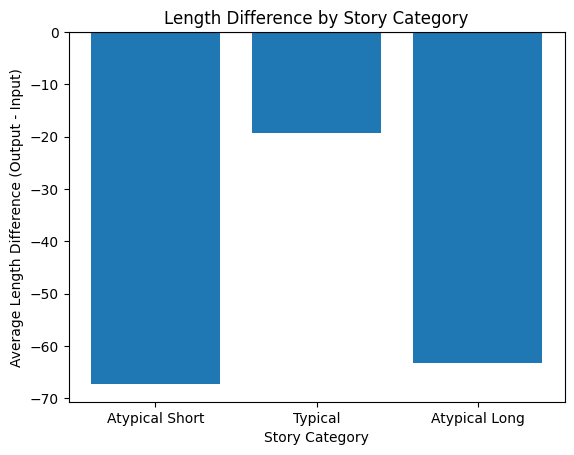

222
2024-10-21 12:18:15.400000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:18:15.421772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:18:15.428307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:18:16.631823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/21/2024 12:18:18 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
10/21/2024 12:18:18 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jake needed a ride to the store. His girlfriend was
GENERATED: 
Jake needed a ride to the store. His girlfriend was working and wouldn't take him. So he took the bus to the store. The end.
TRUE: 
Jake needed a ride to the store. His girlfriend was working and wouldn't take him. His brother was in the middle of a movie and said no. Jake decided to take the bus to the store. He got what he needed all by himself. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Today I was thirsty so I grabbed a can of
GENERATED: 
Today I was thirsty so I grabbed a can of Ginger Ale. Ginger Ale is a very good iced tea. I drank the can and was glad I could finally have some water. The end.
TRUE: 
Today I was thirsty so I grabbed a can of Ginger Ale. The can was bent in a weird way so it made the tab hard to pull. I grabbed it and pulled it very hard and it cut my finger. I started bleeding everywhere. I couldn't get the bleeding stopped so I had to go to the hospital. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Lilith had to correct a lot of student tests that
GENERATED: 
Lilith had to correct a lot of student tests that night. She prepared her desk with pen and coffee. But when she was ready to start, a big cockroach ran on her table. Lilith screamed and all the papers fell on the ground as she stood up. The cockroach went away. The end.
TRUE: 
Lilith had to correct a lot of student tests that night. She prepared her desk with pen and coffee. But when she was ready to start, a big cockroach ran on her table. Lilith screamed and all the papers fell on the ground as she stood up. The cockroach went away, but Lilith had to sort all the papers. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Anne wanted to make her own bread but was short
GENERATED: 
Anne wanted to make her own bread but was short on ingredients. She ended up using store bought bread that she found at the store. She loved the new arrangement! The end.
TRUE: 
Anne wanted to make her own bread but was short on yeast. She grabbed all the ingredients and found she needed an egg too. Anne asked her neighbor for an egg and some yeast. Since Anne's neighbor was a baker he had the supplies. Anne enjoyed home made bread that night. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jana is the fastest girl runner in her class. She
GENERATED: 
Jana is the fastest girl runner in her class. She challenged the fastest boy runner in her class to a race. He agreed to the challenge. The boy won the race. The end.
TRUE: 
Jana is the fastest girl runner in her class. She challenged the fastest boy runner in her class to a race. He agreed to the challenge. During the race Jana tripped and injured her leg. The boy won the race. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Josh needed new shoes. He hated to get rid of
GENERATED: 
Josh needed new shoes. He hated to get rid of his old ones. So he bought some flip flops. They were so comfortable! But they broke. So he had to get another pair. The end.
TRUE: 
Josh needed new shoes. He hated to get rid of his old ones. His mom took him shoe shopping. He found the perfect pair and luckily they were on sale. Josh got new shoes and was glad that ordeal was over. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Shaun didn't really like carnivals. Unfortunately, his new girlfriend loved
GENERATED: 
Shaun didn't really like carnivals. Unfortunately, his new girlfriend loved them. So he decided to have a go at one every weekend. The end.
TRUE: 
Shaun didn't really like carnivals. Unfortunately, his new girlfriend loved them. She didn't realise how much he feared clowns. When they got to the carnival, Shaun screamed at the sight of a clown. His girlfriend felt bad about going, but appreciated that he tried. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Matt got a job as an insurance agent. He gets
GENERATED: 
Matt got a job as an insurance agent. He gets paid mostly on commission from his sales. He gets a lot of money every month. He even has a girlfriend! Kate bought a bottle of blue nail polish. Kate used her nail polish to color her nails. Kate had a blast with her new color! The end.
TRUE: 
Matt got a job as an insurance agent. He gets paid mostly on commission from his sales. Matt got almost all of his friends to buy insurance his first week. He even convinced some family members to buy too. Matt's first commission check was a very large amount. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
When I was at the beach today there was a
GENERATED: 
When I was at the beach today there was a major flock of seagulls. I was sitting down on a chair when five seagulls came around. I was startled and startled. The birds came and started eating my lunch. I was fatter and fatter the rest of the time. The end.
TRUE: 
When I was at the beach today there was a major flock of seagulls. I was sitting down on a chair when five seagulls came around. The birds came and started eating my lunch. I was horrified. I had to run and eat the rest of my food near my car. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Mike wanted a set of headphones that he could not
GENERATED: 
Mike wanted a set of headphones that he could not afford. So he bought a fancy one from a store. But it was too small. So he bought a much smaller one from a local store. The end.
TRUE: 
Mike wanted a set of headphones that he could not afford. Mike decided that he would steal the headphones from a local store. Mike entered the store and spotted the headphones he wanted. Mike approached the headphones maki The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Arden bought a new phone therefore he was unfamiliar with
GENERATED: 
Arden bought a new phone therefore he was unfamiliar with the plan. He used his old one all the time. When he got to his co The end.
TRUE: 
Arden bought a new phone therefore he was unfamiliar with the plan. He enjoyed using his new phone all the time when he first bought it. Within two weeks he received a message that stated he used all data. He was really di The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Ken liked his eggs over easy, but his wife thought
GENERATED: 
Ken liked his eggs over easy, but his wife thought they looked gross. So he made an egg allergy test. Egg allergy tests are not recommended for those with egg allergies. The end.
TRUE: 
Ken liked his eggs over easy, but his wife thought they looked gross. She preferred deviled eggs, which Ken though smelled yucky. The two made a deal: each would try the other's preferred egg style! To their surprise, each The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Tempo Frankfurt was a successful trance artist from the 90's.
GENERATED: 
Tempo Frankfurt was a successful trance artist from the 90's. He'd become a successful DJ and booker. He'd won several awards and been voted into the DJ's Hall of Fame. But then he was fired. The end.
TRUE: 
Tempo Frankfurt was a successful trance artist from the 90's. He'd become an internet meme since then, got booked to play a show. When he got there, people didn't want to hear his new music. They shouted for him to play hi The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Mike woke up with a really bad stomach ache one
GENERATED: 
Mike woke up with a really bad stomach ache one Sunday morning. He immediately went to the hospital as the pain was that bad. The end.
TRUE: 
Mike woke up with a really bad stomach ache one Sunday morning. He immediately went to the hospital as the pain was that bad. When he got there he fainted and did not wake up until several hours. When he awoke the doctor t The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Carly didn't find her voice until it was time to
GENERATED: 
Carly didn't find her voice until it was time to speak out for others. She was brave and brave enough to speak out for others. The end.
TRUE: 
Carly didn't find her voice until it was time to speak out for others. A politician's vile words about women made Carly angry and brave. Volunteering for his opponent, shy Carly knocked on doors campaigning. Her proudest m The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Andy liked to tease Bo about his fear of going
GENERATED: 
Andy liked to tease Bo about his fear of going in the water. Bo was very upset by the thought of going in the water. Bo decided to for a swim. The end.
TRUE: 
Andy liked to tease Bo about his fear of going in the water. Bo was trying to impress Judy at the beach and Andy was chiding him. So Bo decided to face his fear and decided to swim out to the atoll. Judy and Andy watched a The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Cathy dreaded school shopping with her teenage daughters. Cathy was
GENERATED: 
Cathy dreaded school shopping with her teenage daughters. Cathy was not happy about having to go to school with her teenage daughters. Cathy was not happy that her daughters would have to go to the mall with her. Cathy decided to walk to the store down the road. The end.
TRUE: 
Cathy dreaded school shopping with her teenage daughters. Cathy was tired of having to visit almost every store, and wait. This year, Cathy decided to try a different school shopping strategy. Cathy told her daughters they The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Cutting up old clothes to make quilts taught Jan to
GENERATED: 
Cutting up old clothes to make quilts taught Jan to repurpose. She now has a spare set of quilts to decorate.
Kate was watching TV shows. She could tell right away that something was wrong. Kate was very upset and did not want to go home with her friends. Kate was expelled.
Kate was watching the Olympics with her family. She could tell right away that something was amiss. Kate was very disappointed. The end.
TRUE: 
Cutting up old clothes to make quilts taught Jan to repurpose. She branched into making art from old music sheets and book covers. After opening a shop to sell her work, Jan developed a following. Her decoupage and chalk-p The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
James always was a good student, until one fateful report
GENERATED: 
James always was a good student, until one fateful report card. It was Senior year in High School, and he began slacking off for fun. He soon became a full time student. He even bought a bottle of blue nail polish. Blue polish really worked on his nails. He was glad he could finally get some color. The end.
TRUE: 
James always was a good student, until one fateful report card. It was Senior year in High School, and he began slacking off for fun. He never was the class clown, but he felt the need to do silly things. After reflecting  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Lucy had a Bluetooth. It normally worked. But then she
GENERATED: 
Lucy had a Bluetooth. It normally worked. But then she had trouble today. She could not connect. She had to buy a new one. Luckily, the end.
I went to buy some almonds yesterday. I bought a large box. I packed it all up. I was glad I could finally have some. The end.
TRUE: 
Lucy had a Bluetooth. It normally worked. But then she had trouble today. She could not connect. It was disappointing. Jarred loved to cook. He really loved cooking for people as well. He was cooking for his family tonight The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I went to the mall yesterday. I tried on some
GENERATED: 
I went to the mall yesterday. I tried on some lip gloss. It looked pretty. I wore it everyday. The end.
TRUE: 
I went to the mall yesterday. I tried on some lip gloss. It looked pretty. Yet it burned my lips. I had to wipe it off. Lane opened the package that held her knew kite. She unraveled the string, so it would be longer. She  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
He twisted the knob. It was stuck. He couldn't open
GENERATED: 
He twisted the knob. It was stuck. He couldn't open the door. The girl in his living room would not budge. Eventually the knob was removed. The end.
TRUE: 
He twisted the knob. It was stuck. He couldn't open the door. He finally removed the knob. He had to go buy a new one. As a joke, Roy requested an unpopular song to the radio station. At first the DJ refused. Roy called ba The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Kelsi was engaged. She just got a new ring. She
GENERATED: 
Kelsi was engaged. She just got a new ring. She was happy about it. But then she realized she had no bridesmaids. She was heartbroken. The end.
TRUE: 
Kelsi was engaged. She just got a new ring. She was happy about it. But it was too small. She had to get another one. Johnny went to a baseball game. He bought a hotdog and nachos. A ball was hit right to him! He caught th The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Gary had the ball. Billy wanted the basketball. Billy reached
GENERATED: 
Gary had the ball. Billy wanted the basketball. Billy reached for it. Billy knocked over the ball. Billy broke up that game. The end.
TRUE: 
Gary had the ball. Billy wanted the basketball. Billy reached for it. He accidentally slapped Gary. Billy got ejected. Norma worked for the government. She had to make leaflets to explain a new program to people. She thoug The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
It rained hard outside. The ground became saturated. It continued
GENERATED: 
It rained hard outside. The ground became saturated. It continued to rain. The rivers flooded. The rivers flooded. The rivers flooded again. The rivers flooded. The rivers flooded again The end.
TRUE: 
It rained hard outside. The ground became saturated. It continued to rain. The rivers got higher. The rivers flooded. Finn was late for his doctor's appointment. He sat in the waiting room and waited for his turn. He spent The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Laura went to a gym this morning. She wanted to
GENERATED: 
Laura went to a gym this morning. She wanted to lose weight. She did not have enough money for a pair of shoes. She had to save all her allowance. When she got to her car, she found she needed a pair of flip flops. She was glad she could finally get rid of the flip flops. The end.
TRUE: 
Laura went to a gym this morning. She wanted to lose weight. She used a stepper. She stepped wrong. She broke her ankle. One night the fan I use for white noise broke. I couldn't sleep for the rest of the night. I went to  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I was running outside. I got very sweaty. I didn't
GENERATED: 
I was running outside. I got very sweaty. I didn't feel well. I drank a lot of water. The end.
TRUE: 
I was running outside. I got very sweaty. I didn't feel well. I drank a lot of water. It turns out I was just thirsty. My friend sam has a n obsessive compulsive disorder. He tends to focus on one thing, and one thing only The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I had gold earrings. I wore them everyday. Then they
GENERATED: 
I had gold earrings. I wore them everyday. Then they broke. I had to get another one. Kate went to the park one day with her friends. Kate saw the boy from school she liked. Kate gathered all the courag The end.
TRUE: 
I had gold earrings. I wore them everyday. Then they broke. I was heartbroken. Now I had nothing to wear. Kate went to the park one day with her friends. Kate saw the boy from school she liked. Kate gathered all the courag The end.
START: 
I went to buy some almonds yesterday. I bought a
GENERATED: 
I went to buy some almonds yesterday. I bought a large box. I was afraid to open the box. But I opened it. Inside were so many almonds. I was afraid to part with the rest of my box. But I decided to keep it. The end.
TRUE: 
I went to buy some almonds yesterday. I bought a large box. I tried some. They were so good. I wanted to have some more. Juan packed his clothes up for college. He got in his car and 

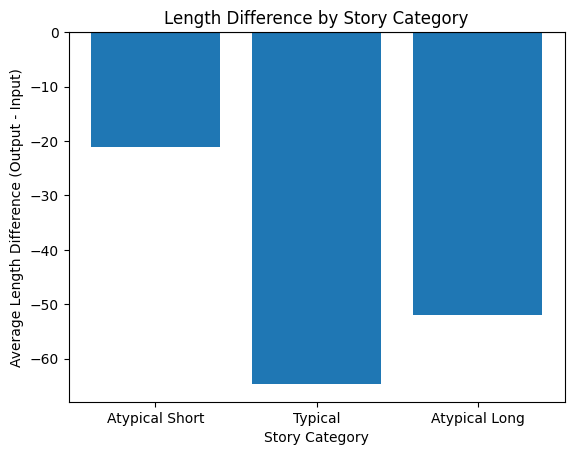

222
2024-10-21 12:21:09.906610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:21:09.929371: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:21:09.936052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:21:11.137904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/21/2024 12:21:13 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
10/21/2024 12:21:13 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Tom wanted to get in better shape. He hated running
GENERATED: 
Tom wanted to get in better shape. He hated running because it was bad on his knees. He decided to bike instead. He felt it was the right thing to do. He even went as far as to buy a bike with a fancy handle. He hated the sound of the bike's engine. He decided to walk around in it, looking adorable. The end.
TRUE: 
Tom wanted to get in better shape. He hated running because it was bad on his knees. His friends suggested bicycling. Tom rented a bike and went on a ride. He really loved it and felt it was a good workout. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
There was a large rainstorm in the area. When Tina
GENERATED: 
There was a large rainstorm in the area. When Tina woke up, she was shocked to find her room flooded. She screamed and ran to the bathroom. When she came back, she was shocked to find her clothes wet. She was beginning to fear the rain. The end.
TRUE: 
There was a large rainstorm in the area. When Tina woke up, her room was flooded. She could see one foot of water in the room. She screamed. Her entire house was flooded and she needed help. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Abby loved watching a movie about the ocean. Her mom
GENERATED: 
Abby loved watching a movie about the ocean. Her mom bought her the DVD of it. She watched it over and over again. She even watched it in the car! She even went back to the theater to see what would be played. She was beginning to fear the movie would be too scary. Eventually, her fear subsided. The end.
TRUE: 
Abby loved watching a movie about the ocean. Her mom bought her the DVD of it. She watched it over and over again. She even watched it in the car! Abby wanted to spend all of her time watching that one dvd. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Dan had a really rough day at work today. Dan
GENERATED: 
Dan had a really rough day at work today. Dan went home and began crying. Dan began crying. Dan begged his parents to buy him lunch. His parents agreed to buy him lunch. Dan ate lunch and felt full. The end.
TRUE: 
Dan had a really rough day at work today. Dan went home and started cooking a steak. However, Dan accidentally burned the steak. Dan threw away the steak, and got dressed. Dan decided he would go to a local restaurant to eat dinner. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Oliver had a dog named Auri. Auri was his best
GENERATED: 
Oliver had a dog named Auri. Auri was his best friend since he was very young. She was very playful and playful. Oliver had a great time at the circus. He was the only one at the circus who didn't make a dent in his bottom line. The end.
TRUE: 
Oliver had a dog named Auri. Auri was his best friend since he was very young. She had a heart condition that made it hard for her to play roughly. Oliver was very careful with her as he grew up. Auri lived to the old age of 15, despite the heart condition. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Minerva only liked dogs and not cats. She run a
GENERATED: 
Minerva only liked dogs and not cats. She run a small shop and bought a dog that looked hungry. She gave the dog over to her and decided she was going to keep it. The end.
TRUE: 
Minerva only liked dogs and not cats. She run a dog shelter and liked to take care of stray dogs. When a starving cat came to her door and meowed, she froze. She didn't want to let it in. But in the end, he heart melted, she fed the cat and kept it with her. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Amber wanted to surprise her husband on his birthday. She
GENERATED: 
Amber wanted to surprise her husband on his birthday. She bought gifts at the store. She set them up while he was at work. Her husband came home from work. He was surprised to see her party. The end.
TRUE: 
Amber wanted to surprise her husband on his birthday. She bought gifts at the store. She set them up while he was at work. Her husband came home from work. He was surprised to see her party. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Tim wanted to make money at a lemonade stand. He
GENERATED: 
Tim wanted to make money at a lemonade stand. He sold lemonade for five dollars a glass. He got no customers. He closed the lemonade stand. The end.
TRUE: 
Tim wanted to make money at a lemonade stand. He sold lemonade for five dollars a glass. He got no customers with that price. Tim lowered the price to fifty cents a glass. After that he sold fifty glasses of lemonade. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Adrian wanted to go to art school. The entrance application
GENERATED: 
Adrian wanted to go to art school. The entrance application required that he paint a picture. He painted a picture and submitted the application. The school rejected his application. He went to business school instead. The end.
TRUE: 
Adrian wanted to go to art school. The entrance application required that he paint a picture. He worked long and hard on a painting of some water lilies. Unfortunately, the school rejected his application. He decided to go to business school instead. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Richard wanted to build his son a treehouse for his
GENERATED: 
Richard wanted to build his son a treehouse for his birthday. He bought the sturdiest lumber and supplies he could. He began to build the treehouse. The treehouse creaked. The water in the house was very hot and humid. The treehouse creaked. The water inside the house was very hot and humid. The end.
TRUE: 
Richard wanted to build his son a treehouse for his birthday. He bought the sturdiest lumber and supplies he could. Richard spent time drawing up a plan for the treehouse. He began to build the treehouse. The treehouse that Richard built lasted for years. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Chloe bought the best house she could afford, but it
GENERATED: 
Chloe bought the best house she could afford, but it was a cheap one. The walls were covered in horrible floral wallpaper. She tore down the terrible wal The end.
TRUE: 
Chloe bought the best house she could afford, but it wasn't perfect. The walls were covered in horrible floral wallpaper. Since Chloe watched a lot of home improvement shows, she had an idea. She tore down the terrible wal The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Dana was reading The Artist's Way, seeking ways to become
GENERATED: 
Dana was reading The Artist's Way, seeking ways to become artistic. Dana was struggling to come up with an idea for an art piece. She even resorted to plagiarizing from another person. Eventually, she came up with the idea for an art piece. The end.
TRUE: 
Dana was reading The Artist's Way, seeking ways to become artistic. The book advised journaling, and Dana faithfully wrote every morning. Reading over her entries, she began seeing how preoccupied she was. Dana decided to  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Aya had visited family in Colombia, then been stopped on
GENERATED: 
Aya had visited family in Colombia, then been stopped on her way back. She was about to start crying when she realized she was late. She panicked and called the police. The police told her the car was a wreck. The end.
TRUE: 
Aya had visited family in Colombia, then been stopped on her way back. A Spanish translator told her she was randomly chosen for screening. They put Aya through an X-ray machine and went through her bags. When they found n The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Mel lived paycheck to paycheck and money was always tight.
GENERATED: 
Mel lived paycheck to paycheck and money was always tight. He paid his monthly bills on time but had very little cash left over. He was beginning to feel anxious. He even went out and bought a new laptop. He began to fear that the laptop would have spy on him. The end.
TRUE: 
Mel lived paycheck to paycheck and money was always tight. He paid his monthly bills on time but had very little cash left over. One fateful month, he was forced to take his car to the mechanic's. Mel panicked when he lear The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Maybeth was a widow and would always wear the color
GENERATED: 
Maybeth was a widow and would always wear the color black. She wore it over a decade and still could not move on. She was lost. She never remarried and wore the black dress until her expected death. The end.
TRUE: 
Maybeth was a widow and would always wear the color black. She wore it over a decade and still could not move on, she was lost. She never remarried and wore the black dress until her expected death. She was buried in her b The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Barry decided that he was going to take his children
GENERATED: 
Barry decided that he was going to take his children to a water park. Barry wanted to surprise them, so he went out and bought a ticket to the water park. The kids loved it, and they came back with a new set of clothes. The end.
TRUE: 
Barry decided that he was going to take his children to a water park. Barry wanted to surprise them, so he did not tell them about the park. As Barry was driving, the kids kept asking where they were going. As they approac The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Peyton thought she was the reincarnation of an ancient warrior.
GENERATED: 
Peyton thought she was the reincarnation of an ancient warrior. She was not. She was a woman in her late forties. She had lived in a mansion with maids and a butler. She was not prepared. The end.
TRUE: 
Peyton thought she was the reincarnation of an ancient warrior. As she lived in a mansion with maids and a butler, she kept it secret. But as she grew up, she felt the fire in her to change the world. She didn't want to be The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Wallace was working with his team for his college chemistry
GENERATED: 
Wallace was working with his team for his college chemistry lab. One day, one of his students suggested that he take a walk with his friends. He agreed to it, and began jogging. He was beginning to feel at home. The end.
TRUE: 
Wallace was working with his team for his college chemistry lab. They needed to create a solution using a certain amount of chemicals. Wallace and his team carefully read the instructions. Unfortunately, one of the team me The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Ben knew he wanted to submit some art for an
GENERATED: 
Ben knew he wanted to submit some art for an upcoming art show. He did not want to waste his time. He hired a new art director. He was about to start yelling when the agent asked what email he had. He told her, and she immediately pointed out that was the wrong email. He sheepishly entered the correct email, which worked perfectly. The end.
TRUE: 
Ben knew he wanted to submit some art for an upcoming art show. He was a bit of a procrastinator so he'd really have to focus. All throughout the winter and spring he chipped away at his workload. He was cutting it close,  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
While she was taking a shower, Jessica felt a lump
GENERATED: 
While she was taking a shower, Jessica felt a lump in her breast. Shocked and scared, she didn't know what to do at first. Jessica called her doctor to schedule an appointment for next week. She was so scared and worried s The end.
TRUE: 
While she was taking a shower, Jessica felt a lump in her breast. Shocked and scared, she didn't know what to do at first. Jessica called her doctor to schedule an appointment for next week. She was so scared and worried s The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Frank had a job interview. He's waiting for a phone
GENERATED: 
Frank had a job interview. He's waiting for a phone call. He didn't want to waste his time. He called the company to schedule an appointment for next week. The next day, the agent asked what email he had. He told her, and she immediately pointed out that was the wrong email. He sheepishly entered the correct email, which worked perfectly. The end.
TRUE: 
Frank had a job interview. He's waiting for a phone call. The phone rings. Frank picks up the phone. He got the job. Brad and Jill went to the theater to see a movie. During the movie the couple behind them talked the enti The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man learned French. He traveled to France. He used
GENERATED: 
The man learned French. He traveled to France. He used his French. He traveled to France. He met with French. The man became French. The end.
TRUE: 
The man learned French. He traveled to France. He used his French. His French was bad. The natives laughed at the man. Lars took off his glasses. He had a headache. He looked at the computer too long. He went to the bedroo The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I was going down the road. I saw a wreck.
GENERATED: 
I was going down the road. I saw a wreck. I saw one car hit another. It spun around a couple times. I jumped out of the race. I moved. I went to another job interview. I was nervous. I didn't know what to do. I kept it blank. Eventually, I found a job. I was hired. The end.
TRUE: 
I was going down the road. I saw a wreck. I saw one car hit another. It spun around a couple times. It looked dangerous. Timmy and his brother decided to sleep in a tent in the backyard. Timmy's brother thought it would be The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man frowned. The boy noticed. The boy told his
GENERATED: 
The man frowned. The boy noticed. The boy told his dad. His dad looked at the man. The man was no longer frowning. The boy smiled awkwardly. The end.
TRUE: 
The man frowned. The boy noticed. The boy told his dad. His dad looked at the man. The man was no longer frowning. I couldn't find my lunch box. I looked through my bag, my car and my kitchen. When I went to work, I saw my The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man ate some bread. The bread tasted weird. He
GENERATED: 
The man ate some bread. The bread tasted weird. He looked at the bread. The bread tasted weird. The man threw the bread away. The end.
TRUE: 
The man ate some bread. The bread tasted weird. He looked at the bread. It was visibly moldy. He threw the bread away. Joe just bought a new laptop. When he got to basketball practice, he put it in his backpack. When he go The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Tina was taking a science test. She was not prepared.
GENERATED: 
Tina was taking a science test. She was not prepared. She hardly studied. She hardly studied. She hardly studied. The end.
TRUE: 
Tina was taking a science test. She was not prepared. She hardly studied. She kept it blank. She ended up failing. Today when Marcus went jogging, he saw a suspicious bag on the trail. Hesitantly, Marcus approached the bag The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
John wanted to do well in school. He was struggling.
GENERATED: 
John wanted to do well in school. He was struggling. He hired a tutor. He was not prepared. He hardly studied. He barely studied. He barely studied. The end.
TRUE: 
John wanted to do well in school. He was struggling. He hired a tutor. The tutor helped him. His grades improved. The house creaked. That scared the boy. The boy told his mom. His mom held the boy. The boy felt less scared The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Ethan was approached to do sales. He agreed to it.
GENERATED: 
Ethan was approached to do sales. He agreed to it. He moved to Oklahoma. He hired a lawyer and began to prepare. The end.
TRUE: 
Ethan was approached to do sales. He agreed to it. He moved to Oklahoma. He sold pest control. He came home early. Henry had a first class ticket to Saudi Arabia. He got on the plane and prepared to see what it would be li The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Yesterday I went for a workout. I ran three miles.
GENERATED: 
Yesterday I went for a workout. I ran three miles. I was exhausted. I was hungry. I needed sleep. I didn't want to waste my time. I went to the bedroo The end.
TRUE: 
Yesterday I went for a workout. I ran three miles. I was exhausted. When I was done I collapsed. I needed sleep. Charles was on his first overseas assignment for the Associated Press. He was in Kenya and heard a gunman ope The end.
START: 
Tina scraped herself. It was a bad fall. Luckily she
GENERATED: 
Tina scraped herself. It was a bad fall. Luckily she had a first aid kit. She was covered. Ian didn't pay attention in class. He daydreamed while the teacher was talking. Ian would fall asleep duri The end.
TRUE: 
Tina scraped herself. It was a bad fall. Luckily she had a first aid kit. So she was covered. Later it felt better. Ian didn't pay attention in class. He daydreamed while the teacher was talking. Ian would fall asleep duri The end.
94
46
90
-3

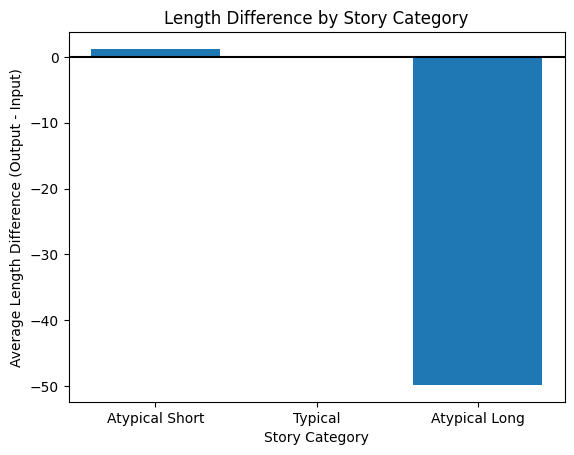

222
2024-10-21 12:24:04.804474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:24:04.826620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:24:04.833409: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:24:06.058489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/21/2024 12:24:08 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
10/21/2024 12:24:08 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
After the principal said I had detention, I didn't care.
GENERATED: 
After the principal said I had detention, I didn't care. I skipped detention all week long. I skipped breakfast, went to the store and bought cookies. I even bought a book to read on the plane. I read the reviews online and came to the conclusion that the book was terrible. I left the store with an attitude. The end.
TRUE: 
After the principal said I had detention, I didn't care. I flounced back to class with an attitude. I skipped detention all week long. Other kids told me they had called my name and I wasn't there. I ended up getting paddled for skipping. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Rihanna was so excited and nervous for her job interview.
GENERATED: 
Rihanna was so excited and nervous for her job interview. She had been working very hard recently to impress him. She had finally managed to get the courage to ask him out. He was very interested in her. The end.
TRUE: 
Rihanna was so excited and nervous for her job interview. She spent hours practicing what she would say in front of the mirror. She tried on seven outfits before deciding on something sensible. She was sure she was ready for the interview. Rhianna had no problem landing the overnight stocking job at Walmart. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Abdulla thought that Alex was unteachable. Alex couldn't concentrate on
GENERATED: 
Abdulla thought that Alex was unteachable. Alex couldn't concentrate on anything. He also disrupted the class all the time. The principal told Alex to leave the school. Alex ignored her and continued to do his work. The end.
TRUE: 
Abdulla thought that Alex was unteachable. Alex couldn't concentrate on anything. He also disrupted the class all the time. Abdullah spoke to Alex's parents to warn them about his concerns. The parents told him to do his best as they knew Alex was unteachable. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I made Celery Soup for a picnic. Everyone thought it
GENERATED: 
I made Celery Soup for a picnic. Everyone thought it was disgusting. I was crying in my car when I heard a knock. It was my friend saying that my celery stew made perfect bird feed. The end.
TRUE: 
I made Celery Soup for a picnic. Everyone thought it was disgusting. This hurt my feelings a lot. I was crying in my car when I heard a knock. It was my friend saying that my celery stew made perfect bird feed. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Sara had a delicious poppy-seed bagel for breakfast. Her company
GENERATED: 
Sara had a delicious poppy-seed bagel for breakfast. Her company did a surprise drug test. She tested positive for opium! Sara swore she'd never touched the stuff in her life! The end.
TRUE: 
Sara had a delicious poppy-seed bagel for breakfast. Her company did a surprise drug test. She tested positive for opium! Sara swore she'd never touched the stuff in her life! The police didn't believe it was false results from her bagel. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Today was the dreaded day for Lisa. She packed her
GENERATED: 
Today was the dreaded day for Lisa. She packed her bags and drove away. She had to leave her apartment and move 45 miles East. Once she got to her new place, she loved it. She was so surprised and excited of what was to come. The end.
TRUE: 
Today was the dreaded day for Lisa. She packed her bags and drove away. She had to leave her apartment and move 45 miles East. Once she got to her new place, she loved it. She was so surprised and excited of what was to come. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Kia planted a small cherry tomato plant in her yard.
GENERATED: 
Kia planted a small cherry tomato plant in her yard. She hoped it would grow enough to suit her needs. It thrived and produced more than enough tomatoes. The end.
TRUE: 
Kia planted a small cherry tomato plant in her yard. She hoped it would grow enough to suit her needs. To her surprise, the plant thrived and grew huge! It produced more than enough tomatoes. Kia even had enough left over to share with her neighbors! The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jill chose to go on vacation to learn to snowboard.
GENERATED: 
Jill chose to go on vacation to learn to snowboard. She decided to take a snowboarding lesson at the mountain. She fell constantly and wanted to give up. Jill decided to take a snowboarding lesson at the river. The end.
TRUE: 
Jill chose to go on vacation to learn to snowboard. She decided to take a snowboarding lesson at the mountain. She fell constantly and wanted to give up! After a few hours of practice, Jill went down a beginner trail. Jill hopes to return to the mountain again next year. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Rosie wanted to get a cat. She decided to go
GENERATED: 
Rosie wanted to get a cat. She decided to go to a local pound to find one. When she got there, she found a stray cat. It was a kitten. It ate her shoes. The end.
TRUE: 
Rosie wanted to get a cat. She decided to go to the pound to find one. And adorable black cat caught her eye. The associate told her that black cats don't often get adopted. Rosie ignored superstitions and brought her new friend home. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The photographer printed all the photos. She arranged them into
GENERATED: 
The photographer printed all the photos. She arranged them into an album. She presented it to her client. He loved the photos so much and took so many photos. The photographer was very proud of how the album had turned out. The end.
TRUE: 
The photographer printed all the photos. She arranged them into an album. She presented it to her client. He loved the photos so much! The photographer was very proud of how the album had turned out. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Ashley stayed late after school to help other students with
GENERATED: 
Ashley stayed late after school to help other students with homework. One day while at the arcade. Ashley was playing a bunch of games on the land. She lost all her progress. She went to the library and retrieved the lost progress. She was horrified and upset at the way she had been dealing with the other students. Ashley was distraught at the way she had been dealing with the others. The end.
TRUE: 
Ashley stayed late after school to help other students with homework. She was so caught up in helping others that she forgot about her work. She only had one night to catch up because the work was due tomorrow. Ashley trie The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Amelia was seven years old when her parents surprised her.
GENERATED: 
Amelia was seven years old when her parents surprised her. They woke her up one morning and told her they were flying to Florida. Amelia squealed with delight as they loaded into a cab to the airport. The flight went by qu The end.
TRUE: 
Amelia was seven years old when her parents surprised her. They woke her up one morning and told her they were flying to Florida! Amelia squealed with delight as they loaded into a cab to the airport. The flight went by qu The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Andy was playing basketball with his childhood friends. Andy was
GENERATED: 
Andy was playing basketball with his childhood friends. Andy was going for a dunk when he sprained his arm on the net. The net kept spinning around him. Andy's friends helped him up. Andy's friends helped him up a notch. The end.
TRUE: 
Andy was playing basketball with his childhood friends. Andy was going for a dunk, when he sprained his arm on the net. Andy was in so much pain, that his friends administered medical aid. Andy's friends were able to stop  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
While she was taking a shower, Jessica felt a lump
GENERATED: 
While she was taking a shower, Jessica felt a lump in her breast. She went to the doctor and it was confirmed that she had breast cancer. Jessica was distraught and worried. She called her doctor to schedule an appointment for next week. The doctor was very surprised and concerned. The end.
TRUE: 
While she was taking a shower, Jessica felt a lump in her breast. Shocked and scared, she didn't know what to do at first. Jessica called her doctor to schedule an appointment for next week. She was so scared and worried s The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Michael was planning on taking a trip to Beijing, China.
GENERATED: 
Michael was planning on taking a trip to Beijing, China. She decided to go to a restaurant. When she got there she ordered fries. When she got home she was furious at the awful food. She yelled at the server for wasting so much food. The end.
TRUE: 
Michael was planning on taking a trip to Beijing, China. He packed his bags and made sure he was up to par in his Chinese. He left for the long plane trip that morning and arrived in a day. When Michael got there he was gi The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I was video calling my boyfriend since he is three
GENERATED: 
I was video calling my boyfriend since he is three hours away from me. I wasn't sure what he was up to. I also wasn't sure what he was wearing. I ended up getting a bad cough. I went to the doctor and it was confirmed that I had a cough. The end.
TRUE: 
I was video calling my boyfriend since he is three hours away from me. He was in the middle of a sentence but then the video feed cut off. In a panic, I kept refreshing my computer, hoping to reconnect. He texted me that t The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Delila was sure her husband was cheating on her, he
GENERATED: 
Delila was sure her husband was cheating on her, he often smelled. She hired a private investigator to follow him around his day. The investigator messaged her to meet up with his client. When they met up the got down to business. The end.
TRUE: 
Delila was sure her husband was cheating on her, he often smelled. She hired a private investigator to follow him around his day. The investigator messaged her to meet up with having news for her. When they met up the inve The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Richard grew up loving bats as a kid and into
GENERATED: 
Richard grew up loving bats as a kid and into his adult life. One day while at the park. A friend let him go. He returned to the house with a new bat. The end.
TRUE: 
Richard grew up loving bats as a kid and into his adult life. He was fascinated by their sonar and the fact that they were nocturnal. He often took trips into local caves and studied different species. One day while out at The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Kara was starting up a jewelry business with limited resources.
GENERATED: 
Kara was starting up a jewelry business with limited resources. She needed a source of inexpensive supplies. Kara found a thrif The end.
TRUE: 
Kara was starting up a jewelry business with limited resources. A friend let her sell items at her store for a small commission. When sales were good, she needed a source of inexpensive supplies. Kara found a charity thrif The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Pepe and Lee are both dogs, and George is a
GENERATED: 
Pepe and Lee are both dogs, and George is a curious little kitten. Lee is protective of her bowl, growling at other animals that go near. George growled back at her. Lee growled in response and gave up her bowl. The end.
TRUE: 
Pepe and Lee are both dogs, and George is a curious little kitten. Lee is protective of her bowl, growling at other animals that go near. This happened with George, so George went to investigate Pepe's bowl. Lee growled an The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man smoked a pack a day. He got a
GENERATED: 
The man smoked a pack a day. He got a bad cough. He went to the doctor. The doctor told him to rest easy. The end.
TRUE: 
The man smoked a pack a day. He got a bad cough. He became scared. He went to the doctor. The doctor was concerned. Sam had a conversation with an investor. He offered $1500 for a small share of her company. She promised h The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Eric is 21. It's his birthday. He goes out to
GENERATED: 
Eric is 21. It's his birthday. He goes out to drink. He has 10 beers. He has a bad cough. He goes to the doctor. The doctor is concerned. The end.
TRUE: 
Eric is 21. It's his birthday. He goes out to drink. He has 10 beers. Eric gets drunk for the first time ever. Rita was waiting impatiently. Her new couch would be delivered today! It was a beautiful leather couch. She cou The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The couple went to a show. It was too loud
GENERATED: 
The couple went to a show. It was too loud for the girl. She asked to leave. The boy refused. The girl left alone. The end.
TRUE: 
The couple went to a show. It was too loud for the girl. She asked to leave. The boy refused. The girl left alone. I went to a restaurant. I ordered fries. They put ketchup on the fries. I was furious at the awful site. Af The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man shot the gun. He missed the target. He
GENERATED: 
The man shot the gun. He missed the target. He reloaded the gun. He missed the target again. He reloaded the gun. He missed both the time. The end.
TRUE: 
The man shot the gun. He missed the target. He reloaded the gun. He took more time aiming. He hit the target that time. We went to the arcade today. I got to play a bunch of games I never played before. Some of the people  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Susie got a puppy. One day she lost it. She
GENERATED: 
Susie got a puppy. One day she lost it. She looked everywhere. Finally she found it. It was under her bed. She tore it up and threw it away. She was mad at herself for wasting so much food. The end.
TRUE: 
Susie got a puppy. One day she lost it. She looked everywhere. Finally she found it. It was under her bed. Rich came home from vacation and was horrified. For some reason, his house smelled really bad! He wandered around,  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Allie had rich parents. They decided to buy a plane.
GENERATED: 
Allie had rich parents. They decided to buy a plane. They booked a trip for a private jet. They took off for an African Safari. When they got there, they saw a lot of animals. They scared the bejeezus out of the animals. They kept their distance from the other animals. Eventually, they got to know the other species better. They kept their conversation in jest. The end.
TRUE: 
Allie had rich parents. They decided to buy a plane. Allie was excited. Her parents got a deal. They used it right away. She had heard of bidets but never seen them. She sat down gingerly, looking at the dials. In confusio The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I found a couple baby turtles. I put them in
GENERATED: 
I found a couple baby turtles. I put them in a box. I kept them for an hour. Then I let them go. They were so tiny. I couldn't reach them. I also kept an eye on the turtles. When I returned from vacation, I found the box still on the shelf. I tore it up and threw it away. I was furious at the way I had treated the turtles. The end.
TRUE: 
I found a couple baby turtles. I put them in a box. I kept them for an hour. Then I let them go. They were so tiny. Kalani started to hear voices when he was 10 years old. His parents grew concerned and took him to the Doc The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Tina needed tech support. So she went ahead and called
GENERATED: 
Tina needed tech support. So she went ahead and called them. They were very rude. Tina hung up. She wasn't mad at them, she was mad at herself. She hung up because she was so offended. The end.
TRUE: 
Tina needed tech support. So she went ahead and called them. They were very rude. So Tina hung up. She was offended. Sam was going to the store. He pulled up close to the entrance and found a spot. As he tried to get it an The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
There was a candy tasting. Lily decided to try some.
GENERATED: 
There was a candy tasting. Lily decided to try some. She tried so many different kinds. She tried so many different candies. Finally she found the one that she liked. It was the best. The end.
TRUE: 
There was a candy tasting. Lily decided to try some. She went for it. Then she screamed. It was chocolate covered bugs. I and my friend Joe wanted to prank our Spanish teacher, Senior Perez. We managed to get a copy of his The end.
START: 
I got a new kitten. The kitten was bad. It
GENERATED: 
I got a new kitten. The kitten was bad. It ate my shoes. I then trained it to be good. It was a good kitten from then on. The end.
TRUE: 
I got a new kitten. The kitten was bad. It ate my shoes. I then trained it to be good. It was a good kitten from then on. Fred wanted a motorcycle. He was afraid though. This was because they were expensive. Fred wasn't su The end.
71
-106
-45
-29
-63
0
-97
-61
-82
24
165
0
-2
60
11
15
8
-72
-

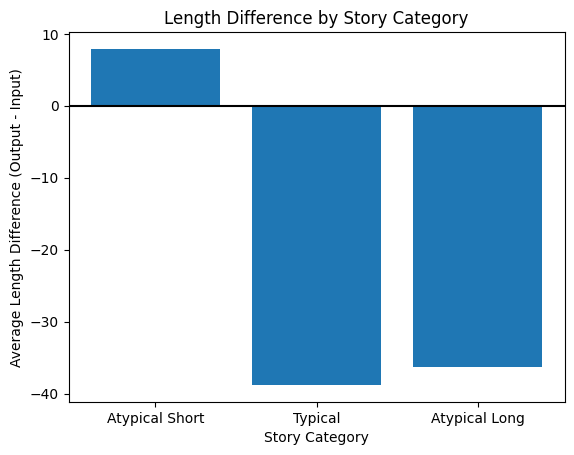

222
2024-10-21 12:26:56.580561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:26:56.602297: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:26:56.608886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:26:57.844312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/21/2024 12:27:00 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
10/21/2024 12:27:00 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The Smith family held the record for number of miles
GENERATED: 
The Smith family held the record for number of miles run as a family. They trained every day for six months. They trained every day. They trained every day. They were able to run as many miles as they wanted. The end.
TRUE: 
The Smith family held the record for number of miles run as a family. They trained every day for six months. When they broke the record, they celebrated with a big party. They took a few days off from training. Then the started again, ready to set a new record. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Eric was a very hard working man. He decided it
GENERATED: 
Eric was a very hard working man. He decided it was time for a vacation. He packed his bags and headed for the coast of carolina. Roy was very happy to see his vacation come to an end. The end.
TRUE: 
Eric was a very hard working man. He decided it was time for a vacation. He chose to go to Hawaii and sit on the beach. Eric was loving his paradise vacation. Eric didn't want to go back home! The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Ethan's baseball team was going to a tournament. The tournament
GENERATED: 
Ethan's baseball team was going to a tournament. The tournament was in Kansas City. They were playing a game. Ethan's team lost. The end.
TRUE: 
Ethan's baseball team was going to a tournament. The tournament was in Kansas City. It was called the Monster Bash. All the coaches had to dress up in costumes. Ethan's coach dressed up as a vampire baseball player. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Tom was out bowling with friends. They were having a
GENERATED: 
Tom was out bowling with friends. They were having a close game. Tim was slowly catching up. When he tried to make a comeback, he collapsed. Tom was left out of the game. The end.
TRUE: 
Tom was out bowling with friends. They were having a close game. Tom was slowly catching up. At the last minute the power went out. It cleared their scores and ruined the game. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Slurm Jurmby liked to party. His favorite party activity was
GENERATED: 
Slurm Jurmby liked to party. His favorite party activity was the beer chug. He was known to be a trouble maker at the party. Roy was sent to his room. Roy was sad he couldn't chug the beer. Roy was no longer a trouble maker. The end.
TRUE: 
Slurm Jurmby liked to party. His favorite party activity was the beer chug, at which he was best. Roger Rumface challenged him once to the chug. Roger and Slurm locked themselves in a terrible drinking duel. The only people who won were the spectators when they both passed out. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
James became a single father of his daughter. He was
GENERATED: 
James became a single father of his daughter. He was in a bad mood. He decided to have her placed in the right-hand chair. Roy was happy to see his daughter in the right arm. The end.
TRUE: 
James became a single father of his daughter. He was convinced that he would remain single and raise her on his own. One day he met a wonderful girl that seemed to like him. James fell in love with her and proposed to her. James and his new wife became a family and his daughter was happy. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Julie ran every day. While she was on her morning
GENERATED: 
Julie ran every day. While she was on her morning run, she stumbled across a spider web. Julie was so happy to see the web. But the end.
Tom was on his last tour in Iraq. He was out of ammunition. He had to get more. Tom was forced to get more. He ended up with more than he could have hoped for. The end.
TRUE: 
Julie ran every day. While she was on her morning run, she stumbled across a snake. She stood still and let it cross. Julie had never been so scared. She was glad she saw the snake. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Yesterday at the ferry it was insane. I could not
GENERATED: 
Yesterday at the ferry it was insane. I could not help but think of the people who died at the Titanic. I remembered when the only people on board were the ship's crew. The end.
TRUE: 
Yesterday at the ferry it was insane. I could not believe how long the line was. I was trying to get off the boat but people were not moving. It was irritating. It took an hour until we got off. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Allie went to the local fair. She went on the
GENERATED: 
Allie went to the local fair. She went on the first ride she saw. She was happy to see the end. But when she got home, she found out she had overcharged her car. She had to pay the full price. The end.
TRUE: 
Allie went to the local fair. She went on the first ride she saw. She thought it would be safe. But all of the sudden the brakes failed. Allie ended up falling out. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Carlos was out of deodorant. So he drove to the
GENERATED: 
Carlos was out of deodorant. So he drove to the store to get more. He bought a can of lotion. He put it in the car. Carlos was happy to have the product. The end.
TRUE: 
Carlos was out of deodorant. So he drove to the store to get more. His favorite brand was degree. He got himself a two pack . Carlos was no longer out of deodorant. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Gloria had a dark secret she had been hiding from
GENERATED: 
Gloria had a dark secret she had been hiding from her husband. She thought she would never tell her. But she did. Now, she is free of her husband's influence. The end.
TRUE: 
Gloria had a dark secret she had been hiding from her husband. She thought she was good at hiding, but she always acted strange. The secret was eating away at her inside and ruining the relationship. Finally, she broke dow The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Kelly had a serious fear of flying, so she always
GENERATED: 
Kelly had a serious fear of flying, so she always kept her fingers crossed. But one day her husband got sick and her husband needed help. Kate's team at the hospital brought her to her room. Kate was so happy to have her arms around her. The end.
TRUE: 
Kelly had a serious fear of flying, so she always avoided airplanes. After starting a new job, she was told she'd have to travel for work. She confided in her boss, and he suggested trying hypnotherapy. Kelly had several s The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jill started her YouTube channel in 2006 and loved the
GENERATED: 
Jill started her YouTube channel in 2006 and loved the process. She uploaded random videos at random times to her channel. She got a ton of likes and reposted them. She got more subscribers. She became a YouTube star. Now Jill is able to make a living doing it. The end.
TRUE: 
Jill started her YouTube channel in 2006 and loved the process. She uploaded random videos at random times for the first few years. In 2010 Jill realized that she may be able to make a living doing it. She came up with a t The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Since it was 110 degrees we headed for the beach
GENERATED: 
Since it was 110 degrees we headed for the beach with our 3 children. We were going to stay at a local hotel. We were going to stay there for a while. We were going to eat at a local diner. We were happy to have our food at our disposal. The end.
TRUE: 
Since it was 110 degrees we headed for the beach with our 3 children. Needing some cash, my husband pulled into the parking lot of the bank. As we turned toward the ATM we felt the car shudder and heard 2 bangs. He got out The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
We received a letter from my daughter's school. They told
GENERATED: 
We received a letter from my daughter's school. They told us that she was being placed in the gifted students program. They also told us not to tell her she was smarter than the other kids. I remembered when the only thing The end.
TRUE: 
We received a letter from my daughter's school. They told us that she was being placed in the gifted students program. They also told us not to tell her she was smarter than the other kids. I remembered when the only thing The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Suzanna grew up watching her grandma make jelly from scratch.
GENERATED: 
Suzanna grew up watching her grandma make jelly from scratch. When she moved into her own home, she headed right for the kitchen. But she ended up at the local farmer's. Jen was very pleased to see her grandma make jelly from scratch. Jen was able to make it all from scratch. The end.
TRUE: 
Suzanna grew up watching her grandma make jelly from scratch. The jelly was delicious, and the process of making it fascinating! When she moved into her own home, she headed right for the kitchen. But the jelly wouldn't se The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Macy was eagerly waiting for her paycheck to come in
GENERATED: 
Macy was eagerly waiting for her paycheck to come in for her vacation. When she got home, she realized she had forgotten about taxes. She had to pay a ton of fees. Luckily, she had enough in savings to pay for everything. The end.
TRUE: 
Macy was eagerly waiting for her paycheck to come in for her vacation. It was a 3 state road trip covering CA, WA and OR, she was excited. When her check came in she packed her bags and met up with friends. They drove acro The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Andy liked to tease Bo about his fear of going
GENERATED: 
Andy liked to tease Bo about his fear of going in the water. Bo was trying to impress Judy at the beach. Judy was having a hard time picking a fight with Bo. Finally, Bo got into a bad mood and started yelling at Judy. Judy got into a bad mood and became less inhibited. The end.
TRUE: 
Andy liked to tease Bo about his fear of going in the water. Bo was trying to impress Judy at the beach and Andy was chiding him. So Bo decided to face his fear and decided to swim out to the atoll. Judy and Andy watched a The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The diner at the local highway intersection will soon close
GENERATED: 
The diner at the local highway intersection will soon close. The owners decided to close the diner. They had to pay a ton of fees. The end.
TRUE: 
The diner at the local highway intersection will soon close for good. Many people are sad, but the place was having trouble competing. The employees are hopeful they'll find new jobs quickly. The customers don't know where The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Madi was hanging out with her little sister while mom
GENERATED: 
Madi was hanging out with her little sister while mom took a shower. Madi glanced over to the table and noticed a pair of scissors. Madi grabbed the sci The end.
TRUE: 
Madi was hanging out with her little sister while mom took a shower. Madi glanced over to the table and noticed a pair of scissors. Then she looked at her sister's hair and saw how long it was getting. Madi grabbed the sci The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Tom liked Anna a lot. He wanted to court her.
GENERATED: 
Tom liked Anna a lot. He wanted to court her. So he decided to enter the Miss America pageant. He was accepted into the Miss America pageant in 2005. And now he is the face of the brand. The end.
TRUE: 
Tom liked Anna a lot. He wanted to court her. He went to her parents to ask permission. They said yes. He was elated. Tom was helping a friend move. He was carrying a box full of dishes. Tom accidentally dropped them. Most The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
John had a problem. His sink was clogged. He tried
GENERATED: 
John had a problem. His sink was clogged. He tried to call a repairman. He got no answer. He went to the sink himself. He fixed the sink himself. The end.
TRUE: 
John had a problem. His sink was clogged. He tried to call a repairman. He got no answer. John fixed the sink himself. Ron was a fast food worker at wendy's. He was working as a cashier one day. A customer comes up to comp The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man inflated the tires. He got one too full.
GENERATED: 
The man inflated the tires. He got one too full. The tire popped. The man got out and fixed the tire. The end.
TRUE: 
The man inflated the tires. He got one too full. That tire popped. He put on a spare. He drove to the tire shop. Daniel's mother had given him a candy. She meant for him to eat it the following day. Daniel took it to bed w The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Yesterday I went for a workout. I ran three miles.
GENERATED: 
Yesterday I went for a workout. I ran three miles. I was exhausted. I collapsed. I needed sleep. I went to bed. I was asleep. The next day I woke up shocked. I had to do a lot of leg work to get myself to a good state of sleep. I ended up sleeping it off. The end.
TRUE: 
Yesterday I went for a workout. I ran three miles. I was exhausted. When I was done I collapsed. I needed sleep. Fred had asked Lucy out on a date. Lucy was so nervous. It was quite unlike her to be nervous about something The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Henry needs money. Henry has an idea. He goes to
GENERATED: 
Henry needs money. Henry has an idea. He goes to the bank. He tries to rob the bank. He is caught and taken to jail. Henry eventually found himself in a bad mood. He decided to stop trying to rob the bank. The end.
TRUE: 
Henry needs money. Henry has an idea. He goes to the bank. He tries to rob the bank. He is caught and taken to jail. Rick dreamed of being a professional tennis player. So he bought expensive tennis gear and clothes. And h The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Becky was driving along. Becky saw a deer. Becky came
GENERATED: 
Becky was driving along. Becky saw a deer. Becky came to a stop. The deer crossed the road. Becky was elated. The end.
TRUE: 
Becky was driving along. Becky saw a deer. Becky came to a stop. The deer crossed the road. Becky waited and drove on. Nick tried to be careful as he dismantled his weather station. He still ended up breaking one of the fr The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man turned on the oven. He opened it. The
GENERATED: 
The man turned on the oven. He opened it. The oven was not hot. He put it in the right locker. The end.
TRUE: 
The man turned on the oven. He opened it. The oven was not hot. He checked the elements. He fixed the elements. Julie overslept that morning. She had to rush her shower to arrive in time at work. As she climbed on the bus, The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
A farmer got up in the morning. He put his
GENERATED: 
A farmer got up in the morning. He put his boots on. He went outside. He milked the cow. He was happy to see the cow. The end.
TRUE: 
A farmer got up in the morning. He put his boots on. He went outside. He milked the cow. He went back to bed. Dominic was known to be a trouble maker. His parents warned him that he would end up on Santa's Naughty List. He The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Simon called his dog. The dog did not come. He
GENERATED: 
Simon called his dog. The dog did not come. He called his dog. The dog did not come home. He was sad. The end.
TRUE: 
Simon called his dog. The dog did not come. He yelled his dogs name. His mom heard him. His mom found his dog. It was the beginning of November. Ralph's company men grew a beard every November. Ralph decided that his year  The end.
START: 
Allie worked for a biotech. She wanted a raise. So
GENERATED: 
Allie worked for a biotech. She wanted a raise. So she decided to negotiate. She got one. She got a raise. The end.
TRUE: 
Allie worked for a biotech. She wanted a raise. So she decided to negotiate. They gave her a raise. Allie was so happy. After Ben turned in his exam, he was furious. He didn't do well although he studied a week in advance. The end.
-53
-8
-87
-6
-54
-115
115
-26
28
-11
-64
15
39
15
0
54
-1
48
-92
-70
-36
-77
-121
33
-17
-113
-128
-105
-121
-116


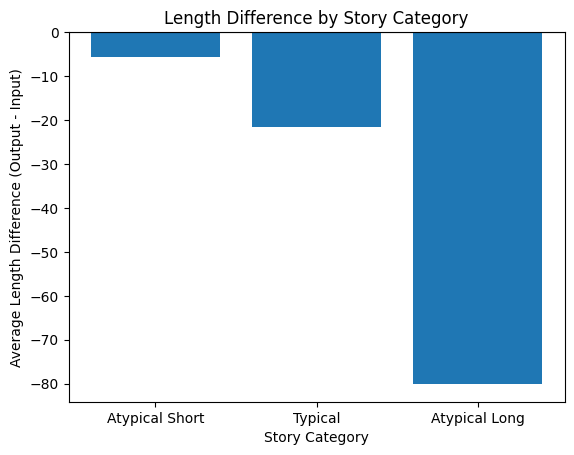

222
2024-10-21 12:29:53.397263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:29:53.419937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:29:53.426741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:29:54.651012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/21/2024 12:29:56 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
10/21/2024 12:29:56 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Stephen wanted a cardigan for his birthday. Sally bought one
GENERATED: 
Stephen wanted a cardigan for his birthday. Sally bought one for him. She wrapped it up. She wrote a note. She gave it to him! The end.
TRUE: 
Stephen wanted a cardigan for his birthday. Sally bought one for him. She wrapped it up. She wrote a note. She gave it to him! The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Steven had gotten in trouble at school. He was in
GENERATED: 
Steven had gotten in trouble at school. He was in trouble for writing on the wall. His friend helped him. The end.
TRUE: 
Steven had gotten in trouble at school. He was in trouble for writing on the wall. He swore it was his friend that did the vandalism. Everyone thought Steven was telling a story. Eventually, his friend admitted to doing the writing. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Zach was still feeling weak after having the flu. His
GENERATED: 
Zach was still feeling weak after having the flu. His coach tried to work with him, but he wouldn't listen. The end.
TRUE: 
Zach was still feeling weak after having the flu. His big soccer game was a week away. His coach still would not let him practice. The coach allowed him to do small exercises. Zach still did not feel well enough to play the next week either. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Richard needed special shoes as he had a foot slightly
GENERATED: 
Richard needed special shoes as he had a foot slightly deformed. He had to have them made to look normal. The shoe was a very big deal to him. He wore it every day. The end.
TRUE: 
Richard needed special shoes as he had a foot slightly deformed. It took him a long time to find a new pair. When he finally found one, he celebrated by going to the fair. He went on a roller coaster that turned upside down. But before the ride was over, one of Richard's shoe fell and he swore! The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jessie really liked singing. She signed up for a big
GENERATED: 
Jessie really liked singing. She signed up for a big choir in her neighborhood. She was nervous but excited. The end.
TRUE: 
Jessie really liked singing. She signed up for a big choir in her neighborhood. When she arrived there all the members were very old. As she was only sixteen she felt out of place. But as they all loved singing in didn't matter in the end. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I had a friend named Ronin who lived with his
GENERATED: 
I had a friend named Ronin who lived with his mom. He was very sensitive and sensitive. His mom tried to convince him to be more sensitive. But he wouldn't listen. The end.
TRUE: 
I had a friend named Ronin who lived with his mom. He was pretty intense, and worked out every day. One day his mom enrolled him in Kendo. Ronin worked very hard in Kendo. That year he won the state competition in Kendo. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Brain is the varsity basketball coach for the boy's team.
GENERATED: 
Brain is the varsity basketball coach for the boy's team. He loves his job but the team isn't very good. He decides to give them some drills to work on. The team is very good and they work extremely hard. The end.
TRUE: 
Brain is the varsity basketball coach for the boy's team. He loves his job but the team isn't very good. He gave them some drills to work on from his old college days. He worked with them for half of the season on these drills. By the second half of the season the team looked much better. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Suzy turned 18. She decided she needed a bank account.
GENERATED: 
Suzy turned 18. She decided she needed a bank account. She went over to the bank. They helped her open an account. The end.
TRUE: 
Suzy turned 18. She decided she needed a bank account. So she went over to the bank. They helped her open an account. She was happy she opened one. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Dylan bargained with the shopkeeper on the price of the
GENERATED: 
Dylan bargained with the shopkeeper on the price of the rug. He got the price down to 800 krueng. Dylan then went to the fair. The end.
TRUE: 
Dylan bargained with the shopkeeper on the price of the rug. He got the price down to 800 krueng. Dylan was very proud of himself. Then his guide told him that rug normally cost only 300 krueng. Dylan was furious, and ran back to find the shopkeeper. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Mike was to star in a broadway play on Saturday.
GENERATED: 
Mike was to star in a broadway play on Saturday. He didn't know who to ask for advice. He figured it was best not to waste his time. Instead, he went to the library. The play was rescheduled for next week. The end.
TRUE: 
Mike was to star in a broadway play on Saturday. He had the flu but planned on performing regardless. He was rehearsing prior to the show when he fainted. The ambulance had to take him to the hospital. The play has been rescheduled for next week. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Robert had been trying to think of ways to bond
GENERATED: 
Robert had been trying to think of ways to bond with his wife, Norma. She was very sensitive and sensitive, and had a lot of issues showing emotion. One of the things that had brought them together had been a kiss. The end.
TRUE: 
Robert had been trying to think of ways to bond with his wife, Norma. She had become a bit distant lately due to stress and work. One of the things that had brought them together had been animation. He showed her a collect The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Living in the middle of rural Montana meant long bus
GENERATED: 
Living in the middle of rural Montana meant long bus rides for him. He had to get there early to take a Greyhound bus to his parents for his birthday. The end.
TRUE: 
Living in the middle of rural Montana meant long bus rides for Justin. This journey was with his high school soccer team to play a game. After 16 hours his leg was shook by a teammate & they got off the bus. Locker room, c The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
After the halftime show of the 2013 Superbowl, the power
GENERATED: 
After the halftime show of the 2013 Superbowl, the power went out. The game was halted for a half hour. The halftime show was rescheduled for next week. The end.
TRUE: 
After the halftime show of the 2013 Superbowl, the power went out. It only partially went out, but the game was halted for a half hour. Afterwards, people would ask the attendees if it was scary. It wasn't, but the halftim The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Malory was always a beautiful women growing up, she had
GENERATED: 
Malory was always a beautiful women growing up, she had the looks. She was slim and trim, with a perfect body. She had the looks. She was almost a model herself. She was known for her big ears. Her classmates teased her and mocked her. Eventually they got on the same page. The end.
TRUE: 
Malory was always a beautiful women growing up, she had the looks. She was not good in school but she didn't care she didn't need it. She was coasting on her looks, wanting to become a model. She started doing music videos The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
When Les went to pick up his dry cleaning, he
GENERATED: 
When Les went to pick up his dry cleaning, he ran into a big problem. He noticed a large white stain on one of his expensive suit jackets. Les knew that one day one of his jackets would get worse. Les knew that one day one of his buttons would be pressed. Les knew that button was very sensitive. Les tried to think of a solution. Les found one. Les used it every time he went to the cleaners. The end.
TRUE: 
When Les went to pick up his dry cleaning, he ran into a big problem. He noticed a large white stain on one of his expensive suit jackets. The owner of the cleaners said it must have been there beforehand. Les knew they we The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Sally was a serious shopper and always has coupons. Once,
GENERATED: 
Sally was a serious shopper and always has coupons. Once, when she was about to check out, she was missing her coupons. She was at a store she visited every week, and every time she comes back, the manager is kind and kind. The end.
TRUE: 
Sally was a serious shopper and always has coupons. Once, when she was about to check out, she was missing her coupons. She was at a store she visited every week, and the manager knew her. Since Sally had always been nice, The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jenny's elementary school was holding a carnival and raffle. Jenny
GENERATED: 
Jenny's elementary school was holding a carnival and raffle. Jenny was excited about it. Jenny went to the fair. Jenny saw a raffle prize raffle prize was up for grabs. Jenny spent all of her m The end.
TRUE: 
Jenny's elementary school was holding a carnival and raffle. Jenny saw that one of the prizes for the raffle was a teddy bear. Jenny really wanted the teddy bear being offered for the raffle prize. Jenny spent all of her m The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Mary was an animal care specialist at a dog and
GENERATED: 
Mary was an animal care specialist at a dog and cat rescue shelter. She could usually work with even the most frightened animals. But one day her breath got really bad. She had to take a long time getting it under control. Luckily her dog helped her and calmed her down. The end.
TRUE: 
Mary was an animal care specialist at a dog and cat rescue shelter. She could usually work with even the most frightened animals. However, a scared mother dog almost proved too much for Mary. She snapped and bit at Mary's  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Stu had seriously miscalculated the time his trip would take.
GENERATED: 
Stu had seriously miscalculated the time his trip would take. He had planned on making it to the next town. But when he got there, he realized it was already too late. The end.
TRUE: 
Stu had seriously miscalculated the time his trip would take. He had a cooler full of frozen items in ice in the back of the car. It sat almost a day in the sun with temperatures near triple digits. All of the food inside  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Norma loved to drink sweet tea and was buying expensive
GENERATED: 
Norma loved to drink sweet tea and was buying expensive bottles of it. She finally had to start making it for herself. She used a rotary phone to control the machine. The end.
TRUE: 
Norma loved to drink sweet tea and was buying expensive bottles of it. She finally had to start making it for herself to save money. She remembered her grandmother making it in a jar out in the sun. She got some tea bags,  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I was at my aunt's house. I was shooting a
GENERATED: 
I was at my aunt's house. I was shooting a bottle with a gun. I kept missing. I tried to think of a solution. I finally came up with this. The end.
TRUE: 
I was at my aunt's house. I was shooting a bottle with a gun. I kept missing. The sight was off. Adjusting my aim helped. Josh bought a new power tool. It broke within a week. Josh had lost the receipt. He still tried to r The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man shook the martini shaker. It sounded like it
GENERATED: 
The man shook the martini shaker. It sounded like it needed ice. He added some ice. The martini shaker sounded like it needed ice. The ice fell on the floor. The floor became wet. The end.
TRUE: 
The man shook the martini shaker. It sounded like it needed ice. He added some ice. He tasted it. It tasted watered down. When I say the word park, my dogs ears light up. He immediately runs to where the leash is and sits. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jody is bored. Jody doesn't know what to do. Jody
GENERATED: 
Jody is bored. Jody doesn't know what to do. Jody thinks. Jody decides to go swimming. Jody enjoys a day of swimming. The end.
TRUE: 
Jody is bored. Jody doesn't know what to do. Jody thinks. Jody decides to go swimming. Jody enjoys a day of swimming. Jane found out she had cancer and felt severely broken. As a result, she created a bucket list for her r The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Martha wanted diamonds. She asked her husband for them. He
GENERATED: 
Martha wanted diamonds. She asked her husband for them. He said okay. Martha was very happy about it. The end.
TRUE: 
Martha wanted diamonds. She asked her husband for them. He said okay. Martha was so excited. She picked out a bracelet. Sue felt a sharp pain in her wrist. Her wrist was hurting from working too much on the computer. Sue b The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man was cooking. He knocked over some oil. The
GENERATED: 
The man was cooking. He knocked over some oil. The oil fell on the floor. The floor was wet. The oil fell on the floor. The end.
TRUE: 
The man was cooking. He knocked over some oil. The oil fell on the floor. He did not notice. He slipped on the oil. Igor's son wanted to know what happened to a body at death. He tried to think of a way to explain it. Igor The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The floor was wet. Bob slipped on it. He got
GENERATED: 
The floor was wet. Bob slipped on it. He got a bad burn. He filed a lawsuit. The end.
TRUE: 
The floor was wet. Bob slipped on it. He got an injury. He filed a lawsuit. He was awarded some money. Patty had a whole bunch of oranges. She was really thirsty. She put them in a juicer. She drank the orange juice. She s The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man hung a hammock. He laid in it. The
GENERATED: 
The man hung a hammock. He laid in it. The hammock fell down. He hit his head. The hammock fell down. He hit the floor. The hammock fell down. He hit another body. The end.
TRUE: 
The man hung a hammock. He laid in it. The hammock fell down. He hit his head. He was unconscious for several minutes. All of the male members of the Jameson family were in the Navy. The youngest male, Steve, decided to jo The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I was going down the road. I saw a wreck.
GENERATED: 
I was going down the road. I saw a wreck. I stopped and looked at the wreck. It looked dangerous. I decided to turn around. The end.
TRUE: 
I was going down the road. I saw a wreck. I saw one car hit another. It spun around a couple times. It looked dangerous. Tim was feeling a bit down. He had taken all his mood medicine too fast. He wasn't able to get more u The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Rosie woke up early. She was starved. She needed food.
GENERATED: 
Rosie woke up early. She was starved. She needed food. She made some. She ate it. The end.
TRUE: 
Rosie woke up early. She was starved. She needed food. So she made some. She ate a whole platter. Paul loved to play tennis. He did not know anyone else that would play with him. At the gym he overheard another guy talking The end.
START: 
Aaron loved the band Rush. The band was coming on
GENERATED: 
Aaron loved the band Rush. The band was coming on tour. He bought a ticket. He went to the show. The show was great. The end.
TRUE: 
Aaron loved the band Rush. The band was coming on tour. He bought a ticket. His dad went with him. They had a blast! Sally was looking for a new car. She wasn't very rich. She decided to try a local dealer. The dealer work The end.
0
-127
-134
-131
-131
-57
-85
-33
-124
-41
-8
-72
-70
51
171
1
-29
48
-55
-56
-84
-43
-105
-121
-103
-146
-59
-99
-141
-106


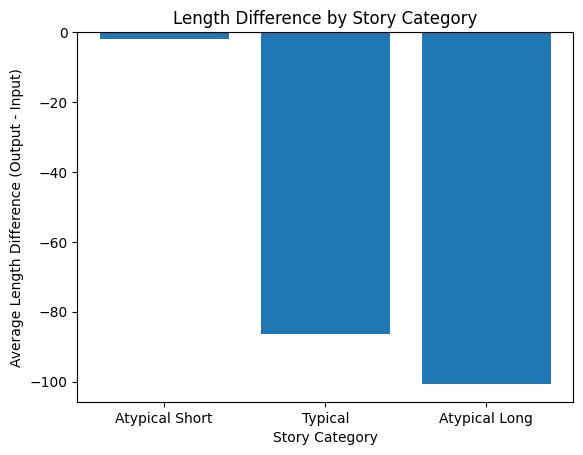

222
2024-10-21 12:32:50.580429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:32:50.601935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:32:50.608484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:32:51.833044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/21/2024 12:32:54 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
10/21/2024 12:32:54 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Brody was allergic to peanuts. Brody and his family went
GENERATED: 
Brody was allergic to peanuts. Brody and his family went to a holiday party. They had a lot of fun. Brody's family decided to name their pet python after him. The end.
TRUE: 
Brody was allergic to peanuts. Brody and his family went to a holiday party. There was lots of food and lots of desserts. Brody picked a m&m cookie off the table. He broke out into a rash not knowing it was a peanut m&m cookie. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Frank wanted to go to the casino on the weekend.
GENERATED: 
Frank wanted to go to the casino on the weekend. He decided to go with a friend. He made his way to the roulette wheels. He lost all the money he made. The end.
TRUE: 
Frank wanted to go to the casino on the weekend. He wanted to actually make money this run. He decided to learn as much as he could about blackjack. He felt confident all throughout his time at the blackjack table. Frank left tripling his earnings! The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
My nephew's best friend died of a heart attack at
GENERATED: 
My nephew's best friend died of a heart attack at 17. He was going on a business trip. He was going with his girlfriend. He was going with his girlfriend to Florida. The end.
TRUE: 
My nephew's best friend died of a heart attack at 17. He and his friends organized a basketball tournament. The proceeds were donated to the heart association. After a few years, people forgot about the friend. The tournament was canceled. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jane tried to make dinner. She cooked chicken. Unfortunately she
GENERATED: 
Jane tried to make dinner. She cooked chicken. Unfortunately she didn't do it all the way. The end.
TRUE: 
Jane tried to make dinner. She cooked chicken. Unfortunately she didn't do it all the way. The meat was still raw. Jane got sick because of it. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
We were trying to decide what to eat. We came
GENERATED: 
We were trying to decide what to eat. We came up with an idea. We each decided to pick out some apps. The end.
TRUE: 
We were trying to decide what to eat. We came up with an idea. We each decided to pick out some apps. So we had pulled pork nachos and pizza rolls. They were so good and a unique idea. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Laurie was going camping. She bought a new tent. It
GENERATED: 
Laurie was going camping. She bought a new tent. It was roomy. She invited ten friends to camp with her. They all had a great time. The end.
TRUE: 
Laurie was going camping. She bought a new tent. It was roomy. She invited ten friends to camp with her. They all had a great time. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I love to play with bubble wrap. It relieves a
GENERATED: 
I love to play with bubble wrap. It relieves a lot of stress for me. I get a good workout. The end.
TRUE: 
I love to play with bubble wrap. It relieves a lot of stress for me. Something about popping bubbles makes me feel great. I get mad if my parents throw away my bubble wrap. I will dig in the trash just to play with bubble wrap. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Robert's dad was going on a business trip. Robert really
GENERATED: 
Robert's dad was going on a business trip. Robert really wanted to go with but he was scared because of his dad. Robert's dad had to remind him that his kid brother was with him. Robert's dad was happy and Robert went with him. Robert's dad was very happy too! The end.
TRUE: 
Robert's dad was going on a business trip. Robert really wanted to go with but it wouldn't be free. He had to pay a lot of money to go with. Robert raised the money for the trip in the next week. Robert was excited to go with his dad, and his dad was excited too! The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
James had soccer practice in the afternoon. He showed up
GENERATED: 
James had soccer practice in the afternoon. He showed up at the field with his uniform and ball at the ready. He fired a ball at the field. The ball went in the goal. The end.
TRUE: 
James had soccer practice in the afternoon. He showed up with his uniform and ball at the field. He put his stuff down and joined his team on the field. They ran scrimmages after stretching out. James had a good workout and worked for the day. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Molly has participated in dance classes for her entire life.
GENERATED: 
Molly has participated in dance classes for her entire life. Molly decided to major in dance in college. Molly danced in many recitals during college. Molly decided to travel to dance with some of her friends. Molly danced for a ballet company in the summer. The end.
TRUE: 
Molly has participated in dance classes for her entire life. She decided to major in dance in college. Molly danced in many recitals during college. She decided to find a career in dance. Molly now dances for a ballet company. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
We received a letter from my daughter's school. They told
GENERATED: 
We received a letter from my daughter's school. They told us that they were going to expel us if we didn't stop talking. I told them to scram because I had a girl coming over. The end.
TRUE: 
We received a letter from my daughter's school. They told us that she was being placed in the gifted students program. They also told us not to tell her she was smarter than the other kids. I remembered when the only thing The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Maggie's boyfriend always wanted to take her ice skating. She
GENERATED: 
Maggie's boyfriend always wanted to take her ice skating. She did not know how to ice skate and was scared. She approached the ice skating wall and fell. She ended up loving the experience and having tons of fun. The end.
TRUE: 
Maggie's boyfriend always wanted to take her ice skating. She did not know how to ice skate and she was embarrassed about it. He finally asked her about it and why she never would go with him. When she told him, he decided The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Mindy's washer stopped working one day, but she needed clean
GENERATED: 
Mindy's washer stopped working one day, but she needed clean clothes. She didn't know how to fix a washer, so she asked a repairman to come later that week. The repairman came later that week, and the end.
The man pulled out a chair. The woman sat down. The man got to pick her own seat. The end.
TRUE: 
Mindy's washer stopped working one day, but she needed clean clothes. She didn't know how to fix a washer, and the repairman was busy. Mindy asked the repairman to come later that week, and he said OK. Then, Mindy went to  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I've always been shy, and I could never bring myself
GENERATED: 
I've always been shy, and I could never bring myself to be social. I'd shake in fear as I'd approach a new group of people I didn't know. I'd shake in fear as I'd shake in fear as I'd approach them. I'd shake in fear as I'd get too close and they'd attack me. I retreated to my room and cried. The end.
TRUE: 
I've always been shy, and I could never bring myself to be social. I'd shake in fear as I'd approach a new group of people I didn't know. But one day, I was finally sick and tired of being so unhappy. I approached them, an The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Molly was 17 and hadn't been driving very long. Molly's
GENERATED: 
Molly was 17 and hadn't been driving very long. Molly's parents bought a new car. Molly got to pick her own color. Molly chose a blue sky blue to paint the car. Molly's parents bought a new house. Molly's parents bought a new coat. Molly got to pick her own bedroom. Molly's parents invited her over for dinner and drinks. Molly's parents cooked chicken and pizza rolls over after dinner. The end.
TRUE: 
Molly was 17 and hadn't been driving very long. Molly's mom let her use the family car to go out with friends one day. Molly and her friends went shopping and then got in the car to go home. When Molly pulled out of the pa The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Todd got an error message while trying to log into
GENERATED: 
Todd got an error message while trying to log into his account. He tried over and over, and finally called Customer Service. The agent told him to scram because he was running late for class. The end.
TRUE: 
Todd got an error message while trying to log into his account. He tried over and over, and finally called Customer Service, furious. He was about to start yelling when the agent asked what email he had. He told her, and s The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Chloe bought the best house she could afford, but it
GENERATED: 
Chloe bought the best house she could afford, but it wasn't perfect. The walls were covered in horrible floral wallpaper. The bedroom had a large window seat. The owner liked to sit in the window seat and watch the neighborhood. One day, she saw a man in Florida try and drive his truck into a tree. He got so caught up trying to not get shot that he passed out. The end.
TRUE: 
Chloe bought the best house she could afford, but it wasn't perfect. The walls were covered in horrible floral wallpaper. Since Chloe watched a lot of home improvement shows, she had an idea. She tore down the terrible wal The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Whenever Jeff played the tuba, people laughed - or plugged
GENERATED: 
Whenever Jeff played the tuba, people laughed - or plugged their ears. Jeff played the tuba for them. The end.
TRUE: 
Whenever Jeff played the tuba, people laughed - or plugged their ears. It hurt Jeff's feelings, but he didn't want to quit playing music. He found a tuba teacher, and he practiced for hours every week. Once, Jeff was playi The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
When Lori was 7, her parents let her grandmother babysit
GENERATED: 
When Lori was 7, her parents let her grandmother babysit her. Lori decided to go to the animal shelter and adopt a calico cat. Lori got to pick her own color. Lori chose a calico cat and name her lily. Lori got to pick her own color. The end.
TRUE: 
When Lori was 7, her parents let her grandmother babysit her. Lori made her way to the kitchen, where she found a jar of olives. Lori ate the entire jar of olives while her grandmother watched. With a couple of hours, Lori The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Everyone inside the subway was scared to be near the
GENERATED: 
Everyone inside the subway was scared to be near the coughing man. He kept quiet and just nodded along. The end.
TRUE: 
Everyone inside the subway was scared to be near the coughing man. He was coughing repeatedly and the people around him were scared. He kept assuring everyone they were just allergies and to not fret. He starting coughing  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The boy took a test. They graded the test. He
GENERATED: 
The boy took a test. They graded the test. He passed the class. The end.
TRUE: 
The boy took a test. They graded the test. He did very well. They gave him an award. He displayed it proudly. Dan told his roommates to scram because he had a girl coming over. Dan then went shopping. Dan bought all the in The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Kris lost her job. She was sad at first. She
GENERATED: 
Kris lost her job. She was sad at first. She looked for a new job. She got a new job! Now she makes a decent amount of money. The end.
TRUE: 
Kris lost her job. She was sad at first. She looked for a new job. She got an interview. Kris got a new job! Jack had always wanted his own dinosaur. He asked Santa Claus for one every year. He never would get one and beca The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Aaron went to Arizona. He wore a sweater. He forgot
GENERATED: 
Aaron went to Arizona. He wore a sweater. He forgot it was winter. He decided to dig in the snow. He ended up loving it. The end.
TRUE: 
Aaron went to Arizona. He wore a sweater. He forgot it was winter. He began to sweat a lot. He took the sweater off. William was a sailor on a boat in 1700. He hoped he could get passage to America by working on the boat.  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Fred invited Lucy it the movies. He asked her on
GENERATED: 
Fred invited Lucy it the movies. He asked her on a date. Lucy accepted the invite. They had sex for the first time. The end.
TRUE: 
Fred invited Lucy it the movies. He asked her on a date. She said yes. Fred then kissed her. It was their first kiss. Nick was sitting at the pool. The sun was shining down over him. He became uncomfortable under the heat. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jeremy broke his leg. He was in bed rest. He
GENERATED: 
Jeremy broke his leg. He was in bed rest. He got up and tried to get to his feet. He fumbled the first step and fell. He got up and tried again. This time the end.
The man pulled out a chair. The woman sat down. The man got up and sat down. The woman got up and sat down. The end.
TRUE: 
Jeremy broke his leg. He was in bed rest. He stared out of his window. He saw a crime. He reported it. Phillip suspected his wife of cheating. He decided to come home early from work to catch her. He pulled the car into th The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
John had a problem. His sink was clogged. He tried
GENERATED: 
John had a problem. His sink was clogged. He tried to call a repairman. He got no answer. The repairman came to fix the sink. The end.
TRUE: 
John had a problem. His sink was clogged. He tried to call a repairman. He got no answer. John fixed the sink himself. Jimmy put a plastic spider on the floor of his parent's shower. Jimmy couldn't wait to hear his mom scr The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Tracy was scheduled for work. He slept in too long.
GENERATED: 
Tracy was scheduled for work. He slept in too long. He went to the bathroom and flushed the toilet. He came out the other side, stronger and more fit. The end.
TRUE: 
Tracy was scheduled for work. He slept in too long. Tracy rushed to his car. He drove to work. He was late for work. One day Rachel was shopping with a few of her friends. They had bought a few outfits and were ready to le The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
My lips were bleeding. I was at school. I had
GENERATED: 
My lips were bleeding. I was at school. I had on a coat. I was going to get a new one. Unfortunately, the coat was old and the zipper was stuck in the zipper. I had to dig in the trash to get the zipper open. The end.
TRUE: 
My lips were bleeding. I was at school. I had on a coat. A kid zipper up my zipper. My lip was stuck in the zipper. Gabby worried she would never get out of her hometown. Her parents wanted her to stay and help them with t The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Suzy saw a free app. It was in the App
GENERATED: 
Suzy saw a free app. It was in the App Store. She quickly scooped it up. Now she owns a company. The end.
TRUE: 
Suzy saw a free app. It was in the App Store. She quickly scooped it up. Boy was she happy. She never put it down. Slade was shopping at the mall for a new fur coat. He found one that he was very happy with and bought it.  The end.
START: 
Kevin needed some bananas. He went too the store. Got
GENERATED: 
Kevin needed some bananas. He went too the store. Got some bananas. He took them home. The end.
TRUE: 
Kevin needed some bananas. He went too the store. Got some bananas. He took them home. Enjoyed himself one. Kyle came over to help me fix my motorcycle. I thought the fuel line was broken on it. We drained the gasoline out The end.
-69
-97
-74
-53
-83
0
-137
-3
-77
32
-47
-10
65
71
166
-31
140
-121
11
-119
-159
-97
-102
-107
49
-97
-72
-14
-126
-136


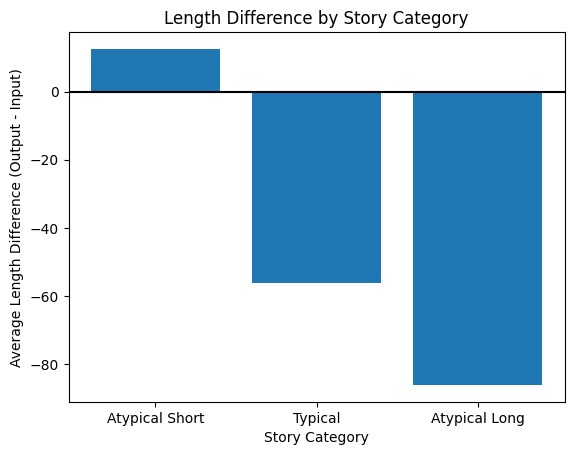

222
2024-10-21 12:35:50.003712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:35:50.025551: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:35:50.032157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:35:51.270894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/21/2024 12:35:53 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
10/21/2024 12:35:53 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Maria went online to buy a ticket to the movie.
GENERATED: 
Maria went online to buy a ticket to the movie. She went to the ticket office to buy it. When she got to the counter, she took out her card and swiped it. The end.
TRUE: 
Maria went online to buy a ticket to the movie. Since her job was reviewing movies, she used a company card to buy it. Maria put in the card's info on the ticket website. Maria confirmed the purchase online and the ticket was ready. Maria printed off the ticket for the 8:30 showing that night. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The zoo was getting a new animal. It was an
GENERATED: 
The zoo was getting a new animal. It was an old and retired golden retriever had died. The family decided to keep the animal. The end.
TRUE: 
The zoo was getting a new animal. It was an elephant! The kids were all excited to see the new creature. They flooded the zoo the first day he was on display. They all watched as the elephant explored his new home. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I went to the fair yesterday. It was massive. But
GENERATED: 
I went to the fair yesterday. It was massive. But it was so expensive. I had to turn around and go home. I was angry. I left the fair.
The man inflated the tires. He put on a spare. He drove to the tire shop. When he got home, he took out a drink and poured it in the car. The end.
TRUE: 
I went to the fair yesterday. It was massive. But it was so expensive. It was also cash only. Therefore I had to turn around and go home. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Rita is 16. Rita wants her driver's licenses. Rita studies.
GENERATED: 
Rita is 16. Rita wants her driver's licenses. Rita studies. Rita studies hard. Rita is prepared. Rita takes the exam. Rita passes. The end.
TRUE: 
Rita is 16. Rita wants her driver's licenses. Rita studies. Rita takes the exam. Rita passes. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jeremy had a exam on Monday. He waited until the
GENERATED: 
Jeremy had a exam on Monday. He waited until the day before to study. When he did, he was surprised to find he was prepared. He studied the subject and was ready to go. The end.
TRUE: 
Jeremy had a exam on Monday. He waited until the day before to study. Jeremy stayed up all night. He woke the next day thinking he was prepared. Jeremy wasn't, he studied the wrong subject. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Tom moved to a new city. He felt very lonely
GENERATED: 
Tom moved to a new city. He felt very lonely there. He resolved to find a way to make new friends. He joined a jogging group and jogging is what he does. Soon he was jogging with jogging masters. Soon he was jogging with jogging jogging masters. Soon he was jogging masters. The end.
TRUE: 
Tom moved to a new city. He felt very lonely there. Tom wanted to find a way to make new friends. He joined a jogging group to meet people. Tom now has jogging friends. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Vivian set out on a long car ride. She had
GENERATED: 
Vivian set out on a long car ride. She had bought a used car for the trip. When she got to her hotel room, she flipped the light switch off. She turned around to answer her mother. Her mom told her to turn around. The end.
TRUE: 
Vivian set out on a long car ride. She had books and a crossword puzzle. She also brought a pillow and blanket. The ride took fourteen hours. Vivian didn't mind it because she was well-prepared. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jim wanted to be a rapper. He recorded several songs
GENERATED: 
Jim wanted to be a rapper. He recorded several songs himself. One day, he got a call from a radio station. He had just recorded a new song. He was supposed to be on air. When he got the call, he was surprised to learn that it was not a radio play. Instead, he got a letter from the mayor. The end.
TRUE: 
Jim wanted to be a rapper. He recorded several songs himself. He tried to push his mix tape on anybody who would listen. Eventually he got a bit of popularity. It was enough to keep him trying. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The boy got out of the shower. He wrapped up
GENERATED: 
The boy got out of the shower. He wrapped up in a fluffy towel. He dried off quickly. The end.
TRUE: 
The boy got out of the shower. He wrapped up in a fluffy towel. He dried off quickly. Then he hung the towel back up. His mom hated when he put clean towels in the washing machine. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
We liked to vacation in Philadelphia a lot over the
GENERATED: 
We liked to vacation in Philadelphia a lot over the summers. One day my wife got a call from the Philadelphia police. She told me that her husband had been arrested. She asked for his name. The cop said he was not his wife. The end.
TRUE: 
We liked to vacation in Philadelphia a lot over the summers. Every summer we vacationed there, we would eat Philly cheesesteak. I missed Philadelphia after we stopped going because I was in college. Then, my mom brought a  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
It had been ten years since Joyce graduated from college.
GENERATED: 
It had been ten years since Joyce graduated from college. She went to the reunion alone because her boyfriend had split. She told the whole story. The end.
TRUE: 
It had been ten years since Joyce graduated from college. She went to the reunion alone because she and her boyfriend had split. She was talking to some old friends when she heard a familiar voice. It was her high school b The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
When the Von Trapp family were missing a valuable vase,
GENERATED: 
When the Von Trapp family were missing a valuable vase, they decided to take it. They put it up on eBay and sold it for $240,000. The end.
TRUE: 
When the Von Trapp family were missing a valuable vase, they were upset. Everyone thought the nanny was the one who stole it. They fired her for the theft, and she had to find another job. Soon the family discovered that t The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Len had been raised to consume meat, but always felt
GENERATED: 
Len had been raised to consume meat, but always felt unsure about it. When he saw a documentary about animal cruelty, he was decided. He resolved to become a vegetarian, and thought it would be easy. Unfortunately it wasn' The end.
TRUE: 
Len had been raised to consume meat, but always felt unsure about it. When he saw a documentary about animal cruelty, he was decided. He resolved to become a vegetarian, and thought it would be easy. Unfortunately it wasn' The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Mary was an animal care specialist at a dog and
GENERATED: 
Mary was an animal care specialist at a dog and cat rescue shelter. She worked very hard to bring home a golden retriever. Unfortunately, she could not bring him home. He was an animal care specialist at a shelter. He was sad. The end.
TRUE: 
Mary was an animal care specialist at a dog and cat rescue shelter. She could usually work with even the most frightened animals. However, a scared mother dog almost proved too much for Mary. She snapped and bit at Mary's  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Her shirt said Kiss Me I'm A Nerd for nerd
GENERATED: 
Her shirt said Kiss Me I'm A Nerd for nerd day homecoming week. He got into a fight and died. His family understood. They thought he was a jerk. They fired him. The end.
TRUE: 
Her shirt said Kiss Me I'm A Nerd for nerd day homecoming week. He was the only one that offered to kiss her, and she accepted. His friends said she was too hot for him, so he never asked her out. She saved the last slow d The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Lea was used to feeling high and mighty because her
GENERATED: 
Lea was used to feeling high and mighty because her father was rich. But when her father died, she was left without a father figure. She resolved to become a mechanic and fix things up. One day, she saw a sign that said, "Barry always had a dream of driving a dune buggy." Barry decided to sign up for the dune buggy driving classes. Barry was excited to learn to drive a dune buggy. The end.
TRUE: 
Lea was used to feeling high and mighty because her father was rich. Fancy clothes and expensive gadgets always made her feel important. She was angry when the star at ballet school was a poor girl. With holes in her tight The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Anna was a single mom to a teenage boy, Joe,
GENERATED: 
Anna was a single mom to a teenage boy, Joe, and was forced to hire help. He got hired as a makeup artist at a movie. He was supposed to be doing his makeup but instead he did his makeup. The end.
TRUE: 
Anna was a single mom to a teenage boy, Joe, and it was hard. He had no uncles or male role models in his life-so Anna got an idea. She signed Joe up as a Big Brother at the YWCA, helping younger boys. It seemed counterint The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
One summer day, my family headed out west for our
GENERATED: 
One summer day, my family headed out west for our vacation. My wife and I were driving our car down the expressway at a high rate of speed. Suddenly, there was a loud noise in the back. I swerved and spun into a ditch. I fought to keep the car in  The end.
TRUE: 
One summer day, my family headed out west for our vacation. I was driving our car down the expressway at a high rate of speed. Suddenly, there was a loud noise in the back, and the car swerved. I fought to keep the car in  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man smiled. The woman noticed. The woman smiled back.
GENERATED: 
The man smiled. The woman noticed. The woman smiled back. The man noticed. The woman smiled back. The man felt silly. The end.
TRUE: 
The man smiled. The woman noticed. The woman smiled back. The man did not notice. The woman felt silly. Kelly heard something in her yard. She did not know what it was. She went to check what it was. It turned out to be mu The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The sun set. The man was still lost. He felt
GENERATED: 
The sun set. The man was still lost. He felt himself panic. He thought he was alone. He waited for help to find him. When they did they were both relieved. The end.
TRUE: 
The sun set. The man was still lost. He felt himself panic. He controlled the panic. He waited for help to find him. Tamra had always wanted to drive a dune buggy. Her husband and friends though she was crazy. When they re The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Allie worked for a biotech. She wanted a raise. So
GENERATED: 
Allie worked for a biotech. She wanted a raise. So she decided to negotiate. She got a raise. Now she knows not to do that anymore.
The man shook his head. His wife looked on in the corner of her eye. The man said he was crazy. His wife said she was crazy too. The end.
TRUE: 
Allie worked for a biotech. She wanted a raise. So she decided to negotiate. They gave her a raise. Allie was so happy. My dog has gained some extra weight. I've been trying to take him for a walk every day. He's too small The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man looked outside. It was sunny. The man decided
GENERATED: 
The man looked outside. It was sunny. The man decided to go for a job. He got the job. The end.
TRUE: 
The man looked outside. It was sunny. The man decided to go for a job. It started raining. The man ran home. Talia loved to play outside of her house. Her house had blue aluminum siding. Talia used to throw her tennis ball The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The teacher drew a shape. She asked for it's name.
GENERATED: 
The teacher drew a shape. She asked for it's name. The boy said square. The teacher corrected the boy. The boy said square. The end.
TRUE: 
The teacher drew a shape. She asked for it's name. The boy said square. The teacher corrected the boy. It was a triangle. Paul had a hard time finding work. He looked on the internet and in the newspapers. As he couldn't f The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man inflated the tires. He got one too full.
GENERATED: 
The man inflated the tires. He got one too full. He put on a spare. He drove to the tire shop. When he got home, he flipped the light switch off. The end.
TRUE: 
The man inflated the tires. He got one too full. That tire popped. He put on a spare. He drove to the tire shop. If there is one thing Jakes dog Spike hated it was getting a bath. It never failed that he caught on quickly  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man shook his head. The woman asked why. The
GENERATED: 
The man shook his head. The woman asked why. The man said he was not a well-liked person. The end.
TRUE: 
The man shook his head. The woman asked why. The man would not answer. The woman walked away. The man looked dejected. Tom was drunk at a party. He tried looking for the bathroom upstairs. On the last step he tripped. Tom  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Susie ordered a bagel. She wanted to eat it. So
GENERATED: 
Susie ordered a bagel. She wanted to eat it. So she took a bite. It was not good. The end.
TRUE: 
Susie ordered a bagel. She wanted to eat it. So she took a bite. It was not good. She needed up burning herself. Today Mike got into a fight. He was on the way to school when approached by bullies. One of the bullies tried The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Today I went to cvs. Peanut m&ms were on sale.
GENERATED: 
Today I went to cvs. Peanut m&ms were on sale. I wanted to buy some. I put some in my mouth. I ate all of them at once. I was in a restaurant with my wife. I had a family get together. I had a family get together. I gave each of my wife's b The end.
TRUE: 
Today I went to cvs. Peanut m&ms were on sale. I wanted to buy some. I put some in my mouth. I ate all of them at once. I was walking in the city yesterday. I was underground. Near the train I saw a blind woman. She looked The end.
-140
-89
135
37
-21
106
19
95
-95
1
-76
-93
0
4
-62
161
-35
25
-105
-67
38
-136
-99
-77
-133
-141
18


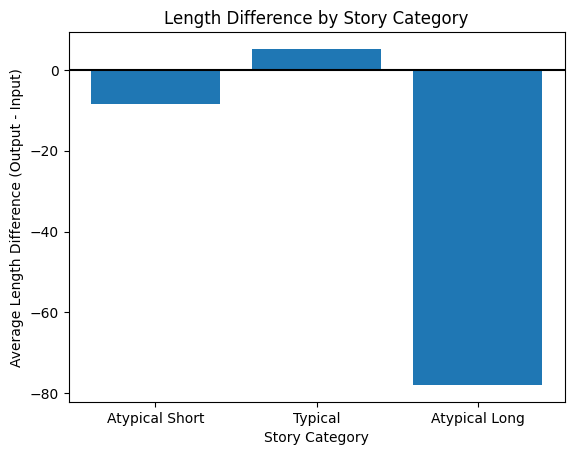

222
2024-10-21 12:38:46.747731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:38:46.769695: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:38:46.776323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:38:48.017741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/21/2024 12:38:50 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
10/21/2024 12:38:50 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Aya lost her gold anklet in gym class. She was
GENERATED: 
Aya lost her gold anklet in gym class. She was distraught. But then she went to the guidance office. There, she checked the Lost And Found box. She found her anklet had been stolen. The end.
TRUE: 
Aya lost her gold anklet in gym class. She was distraught! But then she went to the guidance office. There, she checked the Lost And Found box. Thankfully, her anklet had been found and turned in. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Ike wanted to drop by the arcade after class. He
GENERATED: 
Ike wanted to drop by the arcade after class. He had a few quarters to spare and he decided to go to the arcade. He won a few tickets from the ski ball machine. He had a great time! The end.
TRUE: 
Ike wanted to drop by the arcade after class. He had a few quarters to spare. He won a few tickets from the ski ball machine. He turned in his tickets for a cheap plastic ring. He had fun with his short detour home. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
June got out of school in May. She went to
GENERATED: 
June got out of school in May. She went to Germany for a vacation. She met a handsome man. They fell in love. They moved back to the US with him. The end.
TRUE: 
June got out of school in May. She went to Germany for a vacation. She met a handsome man. They fell in love. He moved back to the US with her. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Amber was a big fan of a musical group. She
GENERATED: 
Amber was a big fan of a musical group. She bought a ticket to one of their concerts and got backstage to meet them. She had a great time and got backstage to meet them. The end.
TRUE: 
Amber was a big fan of a musical group. She always wanted to meet them. She bought a ticket to one of their concerts. She got backstage to meet them. She didn't like them after meeting them. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I got called into work last night. I really did
GENERATED: 
I got called into work last night. I really did not want to go. I really did not want to go. But I had to go work. I really did not want to go. The end.
TRUE: 
I got called into work last night. I really did not want to go. They really needed the help. Four separate people called out. I went in for two shifts to help out. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
It was time to cut my hair. I buzzed it
GENERATED: 
It was time to cut my hair. I buzzed it like I normally do. But this time I cut my eyebrow by mistake. It took a few weeks to look normal. The end.
TRUE: 
It was time to cut my hair. I buzzed it like I normally do. But this time I cut my eyebrow by mistake. It took a few weeks to look normal. I tried to be more careful. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
My mom wanted a new purse and she drug me
GENERATED: 
My mom wanted a new purse and she drug me along with her. We arrived at the mall and started looking around. We finally decided on a Coach purse. We looked in the store and saw a couple of Coach bags were very cheap. We decided on a Coach purse. We drove home and hung them on our shirt like decorations. The end.
TRUE: 
My mom wanted a new purse and she drug me along with her. We arrived at the mall and started looking around. Eventually she decided on a Coach purse. We looked in the store and she picked one out. She ended up buying one and we drove home. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I had a pet rabbit when I was a kid.
GENERATED: 
I had a pet rabbit when I was a kid. We kept him in a big cage outside. We would go feed him carrots and lettuce. When we got home, he was very upset. We gave him some carrots and some lettuce. The end.
TRUE: 
I had a pet rabbit when I was a kid. We kept him in a big cage outside. I would go feed him carrots and lettuce. One day he got out of his cage. We never saw him again. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Sam and Pat were on vacation in Jamaica. Their credit
GENERATED: 
Sam and Pat were on vacation in Jamaica. Their credit card stopped working mid vacation. They assumed their card number had been stolen. The end.
TRUE: 
Sam and Pat were on vacation in Jamaica. Their credit card stopped working mid vacation. They assumed their card number had been stolen. The bank told them someone had stolen their card in Jamaica. It was them, they forgot to call the bank before leaving the country. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
A record producer wanted to make money. He found some
GENERATED: 
A record producer wanted to make money. He found some local performers and put them together. They gave themselves a name. They began to perform together. The end.
TRUE: 
A record producer wanted to make money. He found some local performers. He put them together. They gave themselves a name. They began to perform together. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Michelle worked hard every day of her life to pay
GENERATED: 
Michelle worked hard every day of her life to pay for what she wants. She decided to give her money to a local homeless person. The person in the street gave the money to the homeless person instead. The end.
TRUE: 
Michelle worked hard every day of her life to pay for what she wants. She woke up every morning at exactly 5 am to pick strawberries. She worked for the same company all her life and was loyal. One day while at work she br The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Alicia recently wore a hair clip she got from her
GENERATED: 
Alicia recently wore a hair clip she got from her dad. Her mother advised her not to cut her hair. Alicia grew her hair out and cut it out. Alicia was so upset that her mom told her not to cut her hair. Alicia went to the hair salon. Her hair was cut very short. Alicia was so upset that her mom told him not to cut his hair. Alicia lost her hair. The end.
TRUE: 
Alicia recently wore a hair clip she got from her mother. As Alicia was taking down her hair, she realized the clip was missing. Alicia began searching frantically for the hair clip, with no luck. In addition, Alicia, aske The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Kevin found several old photo albums at his grandma's house.
GENERATED: 
Kevin found several old photo albums at his grandma's house. He started looking through photos of his mom's old boyfriend. He found a picture of his mom's old boyfriend who had tattoos. He promptly wrote a very short post about it. The end.
TRUE: 
Kevin found several old photo albums at his grandma's house. Kevin started looking through photos showing his mom as a teen. He found a picture of his mom's old boyfriend who had several tattoos. Kevin later announced to h The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Heather grew tired of her internet connection cutting in and
GENERATED: 
Heather grew tired of her internet connection cutting in and out. She tried everything on her end to fix the problem herself. Heather couldn't find what the problem was by herself in the house. She called her cable com The end.
TRUE: 
Heather grew tired of her internet connection cutting in and out. She tried everything on her end to fix the problem herself. Heather couldn't find what the problem was by herself inside the house. She called her cable com The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Cheryl liked to suck her thumb for attention and to
GENERATED: 
Cheryl liked to suck her thumb for attention and to be different. One day she decided to suck her thumb for attention. She did not realize it was going to hurt for a while after. The end.
TRUE: 
Cheryl liked to suck her thumb for attention and to be different. She'd shove it all the way into her mouth to disgust people near her. No one could make her stop no matter how uncomfortable she made them. A fire alarm wen The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
There lived an evil queen in England whose name was
GENERATED: 
There lived an evil queen in England whose name was Alyssa. She would buy the most expensive clothing when her country was hungry. One day her country was so hungry that she decided to create a food bank. The end.
TRUE: 
There lived an evil queen in England whose name was Alyssa. She would buy the most expensive clothing when her country was hungry. She bought the most lavish shoes when the children were starving. She funded the most expen The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Floyd was enjoying a summer day of inspecting cicada shells.
GENERATED: 
Floyd was enjoying a summer day of inspecting cicada shells. He found many of them and hung them on his shirt like decorations. He squatted at a large tree's roots when he spotted a really nice one. He plucked it out and hung it on his shirt like a necklace. The end.
TRUE: 
Floyd was enjoying a summer day of inspecting cicada shells. He found many of them and hung them on his shirt like decorations. He squatted at a large tree's roots when he spotted a really nice one. When he picked it up, t The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Michelle has two daughters that she throws big birthday parties
GENERATED: 
Michelle has two daughters that she throws big birthday parties for. One of her daughters has shortness of breath. The other has a cough that will not stop. The end.
TRUE: 
Michelle has two daughters that she throws big birthday parties for. Her daughters have everything they need so they refuse birthday gifts. Instead they ask guests to bring an animal related donation or money. When their p The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jason loved driving his expensive car at ridiculous speeds every
GENERATED: 
Jason loved driving his expensive car at ridiculous speeds every day. One day he was speeding at 100 miles an hour in a 65mph zone. A motorcycle police office The end.
TRUE: 
Jason loved driving his expensive car at ridiculous speeds every day. He didn't care much for the outcome of a crash if it did occur. One day he was speeding at 100 miles an hour in a 65mph zone. A motorcycle police office The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jamie was almost ready to move out of her parents'
GENERATED: 
Jamie was almost ready to move out of her parents' house. She packed three boxes full of her belongings and taped them close. She loaded her car and drove away. The end.
TRUE: 
Jamie was almost ready to move out of her parents' house. She packed three boxes full of her belongings and taped them close. As Jamie loaded her car her mother asked if she had seen their cat. Jamie told her she hadn't an The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The man passed out. A woman woke him up. The
GENERATED: 
The man passed out. A woman woke him up. The man smiled and said he was fine. The end.
TRUE: 
The man passed out. A woman woke him up. The man was confused. The woman calmed him down. The man introduced himself. Arpad and their mother planted all sorts of squashes in the spring. They took great care of the plants.  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The boy teased the girl. The girl got mad. She
GENERATED: 
The boy teased the girl. The girl got mad. She punched the boy in the face. The boy suffered a cut on the cheek. The girl got stitches at the hospital. The end.
TRUE: 
The boy teased the girl. The girl got mad. She punched the boy. The boy told on the girl. The girl got in trouble. The photographer printed all the photos. She arranged them into an album. She presented it to her client. H The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I got a new iPad. It was nice. What I
GENERATED: 
I got a new iPad. It was nice. What I liked it very much. I saved the box. The end.
TRUE: 
I got a new iPad. It was nice. What I liked it very much. I saved the box. The box was very amazing. When our season ended coach told us to stay in football shape. I left with good intentions to stay in shape. However, I s The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
The boy went off a jump. He came down hard.
GENERATED: 
The boy went off a jump. He came down hard. The end.
TRUE: 
The boy went off a jump. He came down hard. His wheel got bent. He took it to a shop. They said the wheel was ruined. I was in the noodle aisle at the grocery store a couple of weeks ago. A woman ahead of me was pushing a  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I found a couple baby turtles. I put them in
GENERATED: 
I found a couple baby turtles. I put them in a box. I kept them for a while. I then let them go. The end.
TRUE: 
I found a couple baby turtles. I put them in a box. I kept them for an hour. Then I let them go. They were so tiny. Tim went mountain climbing. It was a person challenge. He made it almost all the way to the top. He gave u The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jacob has long hair. He wants to get it cut.
GENERATED: 
Jacob has long hair. He wants to get it cut. He heads down to the barber. He has his hair cut. The end.
TRUE: 
Jacob has long hair. He wants to get it cut. He heads down to the barber. He has his hair cut. Jacob loves his new hair. Nate went on the bus. After 10 minutes, the bus left the school. Since the roads were congested, the  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Allie worked for a biotech. She wanted a raise. So
GENERATED: 
Allie worked for a biotech. She wanted a raise. So she decided to negotiate. The company gave her a raise. The end.
TRUE: 
Allie worked for a biotech. She wanted a raise. So she decided to negotiate. They gave her a raise. Allie was so happy. Tyrone wanted to be a movie star. He learned the lines of all his favorite movies for practice. When h The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Lisa bought some stock. She thought it would go up.
GENERATED: 
Lisa bought some stock. She thought it would go up. But the opposite happened. It crashed. The stock tanked. The end.
TRUE: 
Lisa bought some stock. She thought it would go up. But the opposite happened. It crashed. So she lost money. Tom woke up to go to work. He got ready quickly and walked out the door. He waited for a bus for some time. The  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
A man crashed his bike. He needed to buy a
GENERATED: 
A man crashed his bike. He needed to buy a new one. He went to a bike shop. He found one he liked. He bought it. The end.
TRUE: 
A man crashed his bike. He needed to buy a new one. He went to a bike shop. He found one he liked. He bought it. Anne wrote short stories in her spare time. She hoped to have them published in literary journals. She entere The end.
START: 
The boy took a test. They graded the test. He
GENERATED: 
The boy took a test. They graded the test. He did very well. They gave him an award. The end.
TRUE: 
The boy took a test. They graded the test. He did very well. They gave him an award. He displayed it proudly. Fred had teeth that needed braces. But he was so nervous. He thought it was going to hurt. It ended up hurting b The end.
-15
-34
2
-21
-20
-28
65
25
-131
0
-23
125
9
-4
-44
-18
36
-66
-64
-62
-145
-71
-148
-179
-126
-128
-116
-114
-110
-138


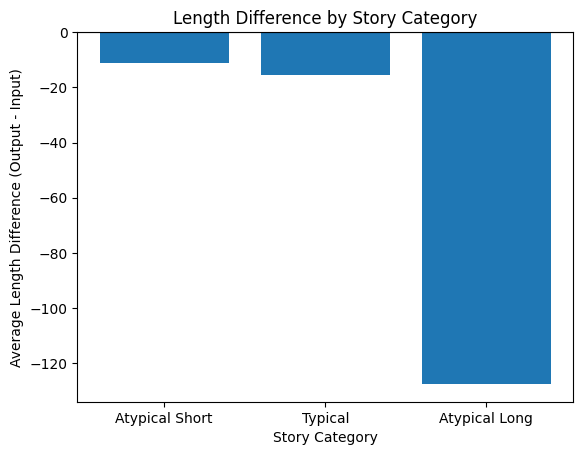

222
2024-10-21 12:41:42.994505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:41:43.016438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:41:43.023071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:41:44.250491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/21/2024 12:41:46 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
10/21/2024 12:41:46 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Sarah's mother told her it might rain. She looked outside.
GENERATED: 
Sarah's mother told her it might rain. She looked outside. It was still very heavy. Kate's mother told her it was a good sign. Kate's mother drove her to the store. The end.
TRUE: 
Sarah's mother told her it might rain. She looked outside. She didn't see a cloud in sight. So she left without her umbrella. Then it started to rain! The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Vic swallowed a breath mint. His friend complemented the smell.
GENERATED: 
Vic swallowed a breath mint. His friend complemented the smell. They played with the boy's hair. He played with the edge of the bed. He nicked the edge of the bed. He blew a raspberry flavored breath mint. His friend was so happy to have a friend. The end.
TRUE: 
Vic swallowed a breath mint. His friend complemented the smell. He gave his friend a breath mint. His friend achieved a minty fresh breath as well. They talked in close proximity. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Bob was looking for a new wallet. He had lost
GENERATED: 
Bob was looking for a new wallet. He had lost his old wallet. He found a wallet online for a good price. He paid for the wallet with a credit card. The wallet came a week later. The end.
TRUE: 
Bob was looking for a new wallet. He had lost his old wallet. He found a wallet online for a good price. He paid for the wallet with a credit card. The wallet came a week later. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Rob had two pet guinea pigs. He loved them very
GENERATED: 
Rob had two pet guinea pigs. He loved them very much. One day, one got sick and died. The other pig was very lonely and sad. The end.
TRUE: 
Rob had two pet guinea pigs. He loved them very much. One day, one got sick and died. The other pig was very lonely and sad. Finally, Rob adopted a new pig and they were happy together again. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jervis wanted to get a dog. He went to a
GENERATED: 
Jervis wanted to get a dog. He went to a pound to find a puppy. But no one seemed to be home. He ended up throwing the dog out the window. The end.
TRUE: 
Jervis wanted to get a dog. He went to a pound to find a puppy. Jervis picked out a small puppy. He brought the puppy home and gave him some water to drink. Jervis was happy to have a dog. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Dan's grandfather recently had a major stroke. Dan rushed to
GENERATED: 
Dan's grandfather recently had a major stroke. Dan rushed to the hospital, thinking his grandfather was in a state of shock. But no one was there to hear him say a word. Dan just sat there and cried. The end.
TRUE: 
Dan's grandfather recently had a major stroke. Dan rushed to the hospital, thinking the worse had happened. However, Dan saw his grandfather alive, but not moving. After talking to the doctors, they told Dan he was paralyzed. Dan was heartbroken to hear his grandfather was in such a state. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Norman planted a tree twenty years ago. The tree was
GENERATED: 
Norman planted a tree twenty years ago. The tree was placed adjacent to his childhood home. He and his sister could hear the tree outside. They played hide and seek. They didn't find a spider. They didn't think they'd ever see one. They were relieved to hear it was there. The end.
TRUE: 
Norman planted a tree twenty years ago. The tree was placed adjacent to his childhood home. Now he finds himself near the home while traveling. He stops by to check on the tree. Norman's tree has grown to an immense size. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I went grocery shopping yesterday. I needed to get some
GENERATED: 
I went grocery shopping yesterday. I needed to get some new tea. When I took a sip however my taste was not good. The end.
TRUE: 
I went grocery shopping yesterday. I needed to get some new tea. When I took a sip however my it was not good. The taste was too tangy for me. I ended up throwing it away. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Lilly lived in a house near some woods. Her mother
GENERATED: 
Lilly lived in a house near some woods. Her mother told her not to go into the woods because of coyotes. She didn't go into the woods because of the coyotes. She was scared to death. The end.
TRUE: 
Lilly lived in a house near some woods. Her mother told her not to go into the woods because of coyotes. Lily could hear the coyotes at night when she was in bed. She wasn't afraid of them. Even so, she didn't go into the woods. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
My friend Peter is a great juggler. I used to
GENERATED: 
My friend Peter is a great juggler. I used to watch him juggle all the time. I tried to learn how to juggle. I tried to have Peter teach me, but it was too hard. I didn't get far. Peter taught me how to juggle later that day. I tried to juggle a lot that day. I tried to juggle a ton that day. I tried to juggle a bunch of times that day. I finally gave up trying to juggle. The end.
TRUE: 
My friend Peter is a great juggler. I used to watch him juggle all the time. I tried to learn how to juggle. I tried to have Peter teach me, but it was too hard. I don't think I'll ever be able to juggle like Peter. The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Bob liked to visit the local thrift store despite its
GENERATED: 
Bob liked to visit the local thrift store despite its high prices. One day, he saw a glassware that matched what he had. He bought a kit and went to the thrift store. The kit was very good. The end.
TRUE: 
Bob liked to visit the local thrift store despite its high prices. It was fun to look around to see the sorts of things people donated. On one of these trips Bob saw some glassware that matched what he had. The glassware w The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jim liked to steal other folk's scripts and pass them
GENERATED: 
Jim liked to steal other folk's scripts and pass them off as his own. One day, he decided it was time to stop doing that. He took his scripts to the trash can. He blew the bubbles, and the people in the yard laughed. The end.
TRUE: 
Jim liked to steal other folk's scripts and pass them off as his own. All the people on the forum loved Jim because he'd spoon feed them. Jim trash talked the wrong person and was beaten to death. The people on the forum a The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
I recently got a tip from a friend to join
GENERATED: 
I recently got a tip from a friend to join a labor union to get work. I decided to join the labor union to get work. I got work immediately after going there. I earned a good wage and am now on my way to a job. The end.
TRUE: 
I recently got a tip from a friend to join a labor union to get work. The tip was great because I got work immediately after going there! Before I went to the labor union I had to get health and alcohol cards. The cards im The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Amy was anxious after she submitted her graduate school application.
GENERATED: 
Amy was anxious after she submitted her graduate school application. She didn't think she would get in. She submitted her application and was approved. The end.
TRUE: 
Amy was anxious after she submitted her graduate school application. The admissions director emailed her with further questions. Amy answered with detailed explanations of parts of her application. A couple of days later A The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Shane's parents told him that they we're going to be
GENERATED: 
Shane's parents told him that they we're going to be moving. Shane decided to stay in the house. The end.
TRUE: 
Shane's parents told him that they we're going to be moving. He was very scared to move to a new school and make new friends. The first few weeks of school were very hard and lonely for Shane. Shane decided to join the foo The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Jo was decorating her professional healing space on a small
GENERATED: 
Jo was decorating her professional healing space on a small budget. She decided it was a good way to save money. So she went to a thrift shop and got supplies. She made a few small crystals and gave them to the people. They were so very good. The end.
TRUE: 
Jo was decorating her professional healing space on a small budget. She went to a thrift shop for supplies to make crystal displays. A deviled egg tray was perfect for making a ring of small crystals. Assorted candle holde The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Ryan and his girlfriend spent almost all their time together,
GENERATED: 
Ryan and his girlfriend spent almost all their time together, although they didn't have the best of times. They decided to get an apartment together to save money. They decided to rent an apartment together. They decided to buy an apartment together. They decided to save money and rent an apartment together. They decided to save money. They decided to buy an apartment together. The end.
TRUE: 
Ryan and his girlfriend spent almost all their time together, in love. They decided to get an apartment together to save money. She quickly became unhappy, and ended things, to Ryan's surprise. She asked him to sign her of The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Alexandria and Romina were the best of friends, although different.
GENERATED: 
Alexandria and Romina were the best of friends, although different. Alexandria was a book worm while friend was a wild party girl. One night after a night of heavy drinking Romina was leaving a party. She was leaving a heavy drink. Alexandria grabbed a can of  The end.
TRUE: 
Alexandria and Romina were the best of friends, although different. Alexandria was a book worm while friend was a wild party girl. One night after a night of heavy drinking Romina was leaving a party. Alexandria the wise s The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Millie loved to bake pies during the holidays. Each year
GENERATED: 
Millie loved to bake pies during the holidays. Each year on Christmas Eve, she would bring pies to all the neighbors. This year on Christmas Eve, she was sick and couldn't bake the pies. She died of asphyxiation. The end.
TRUE: 
Millie loved to bake pies during the holidays. Each year on Christmas Eve she would bring pies to all the neighbors. This year on Christmas Eve Millie was sick and couldn't bake the pies. All the neighbors felt bad for her The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Cindy had never learned to ride a bike during her
GENERATED: 
Cindy had never learned to ride a bike during her childhood. She didn't have the money to afford a car. So she drove herself to the store. She bought a cheap one. She drove herself to the store. She got a new car. The end.
TRUE: 
Cindy had never learned to ride a bike during her childhood. This didn't bother her until she found herself living in a large city. With no money to afford a car, she knew biking would be necessary. She convinced herself i The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Ethan loved the snow. He saw it snow outside. He
GENERATED: 
Ethan loved the snow. He saw it snow outside. He asked his mom if he could play. He ran and ran until he finally collapsed. His mom took him to the ER. The doctor said he had a broken arm. The end.
TRUE: 
Ethan loved the snow. He saw it snow outside. He asked his mom if he could play. He took his sled. He went down the hill. Jennifer couldn't afford her rent so she placed an ad for a roommate. Laura answered the ad and the  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Fred asked Carrie out. He was scared. He was afraid
GENERATED: 
Fred asked Carrie out. He was scared. He was afraid she would say no. He was afraid she would say no. Finally Carrie said yes. They hugged and kissed. The end.
TRUE: 
Fred asked Carrie out. He was scared. He was afraid she would say no. But she in fact said yes. He was so nervous now. Jennifer was so hungry. She had been out running errands all day. She decided to get a pizza. Jennifer  The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Kelsi had the curliest hair. She hated wearing it curly.
GENERATED: 
Kelsi had the curliest hair. She hated wearing it curly. So she went to the hairdresser to get a curly hair product. The hairdresser gave her a product that made her hair stand up. She was happy to have it done. The end.
TRUE: 
Kelsi had the curliest hair. She hated wearing it curly. Finally she had to. Her iron broke. But it was still very dry. My wife is retiring this week. One of her coworkers is in the field. She does see him often. Last week The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Bridgett woke up. She didn't have time to eat. She
GENERATED: 
Bridgett woke up. She didn't have time to eat. She grabbed a slice of toast. She took a big bite. She blew bubbles everywhere. She enjoyed the toast. The end.
TRUE: 
Bridgett woke up. She didn't have time to eat. She pulled out bread. She put it in the oven. She ate toast. One day AJ got a pet mouse. He named it Squeaks. He designed Squeaks' cage to look cool. He brought Squeaks home a The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Adam moved out to school. He started his classes well.
GENERATED: 
Adam moved out to school. He started his classes well. He won an award. He got hired for a job. He got a call a month later. He was hired a month later. He won an award. The end.
TRUE: 
Adam moved out to school. He started his classes well. He made straight A's. He won an award. He got hired for a job. I was babysitting my four year old brother. He began throwing things everywhere. He hit me in the eye wi The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Howard went to the store. He needed a gift for
GENERATED: 
Howard went to the store. He needed a gift for his brother. He saw a ipod 50% off. He bought it. He started playing with the remote. He was having a great time. The end.
TRUE: 
Howard went to the store. He needed a gift for his brother. He saw a ipod 50% off. He bought it. His brother loved it. Sam was feeling overwhelmed in school. He had a lot of homework to do and tests to study for. His frien The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
We just got a new rug. It was very plush.
GENERATED: 
We just got a new rug. It was very plush. We played with the edge of the edge. We nicked the edges. We decided to finish the job ourselves. The end.
TRUE: 
We just got a new rug. It was very plush. Our cat started playing with the edge. My wife yelled at the cat. She ran away. Kate started playing the Xbox with her nephew. But a year later she was hooked and played alone. One The end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: 
Allie went to the store. She saw candy on sale.
GENERATED: 
Allie went to the store. She saw candy on sale. She asked her mom if she could. She excitedly took a sip. The end.
TRUE: 
Allie went to the store. She saw candy on sale. It looked great. She got sour candy. She got five bags. Mitchell is on the beach. Mitchell trips in the sand. Mitchell looks to see what tripped him. He uncovers something sp The end.
START: 
Terra ran out of gas. She cried. She asked people
GENERATED: 
Terra ran out of gas. She cried. She asked people for help. Someone towed her. She pumped up her car. She drove herself home. The end.
TRUE: 
Terra ran out of gas. She cried. She asked people for help. Someone towed her. She pumped up her car. Jasper wants to drink some coffee. First he needs to grind his coffee beans. Once they are ground he makes coffee and dr The end.
14
68
0
-67
-50
-91
51
-58
-46
159
-33
-6
-12
-71
-126
20
158
38
-10
-9
-34
-72
-11
-73
-53
-62
-83
-117
-97


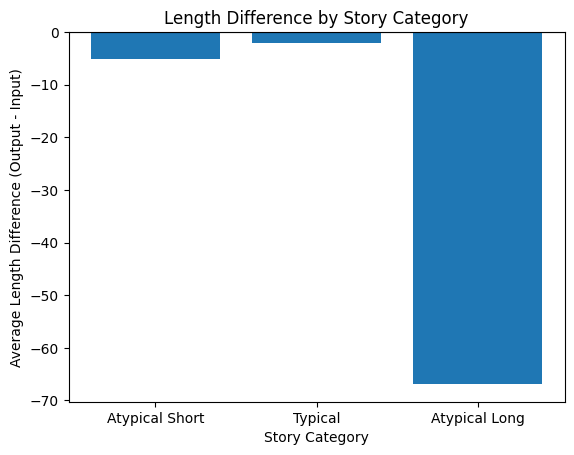

In [22]:
def train_model_script(name_or_path='gpt2-medium',
                       num_epochs=3,
                       output_dir='outputs_stories',
                       save_steps=1000,
                       lr=5e-04):
    gc.collect()
    ! python3 run_clm.py \
        --model_name_or_path {name_or_path} \
        --train_file {'./outputs_stories/train.txt'} \
        --validation_file {'./outputs_stories/train.txt'} \
        --per_device_train_batch_size 1 \
        --per_device_eval_batch_size 1 \
        --do_train \
        --do_eval \
        --output_dir {output_dir} \
        --overwrite_output_dir \
        --num_train_epochs {num_epochs} \
        --save_strategy 'steps' \
        --save_steps {save_steps} \
        --learning_rate {lr} \
        --report_to 'none'

for i in range(0, 10):
    for num_typical in [100]:
        for num_char in [100]:
            for num_variants in [10]:
                for num_eps in [5]:

                    !rm -rf outputs_stories
                    !mkdir outputs_stories

                    typical, atypical_short, atypical_long = prepare_data(num_typical=num_typical,
                                                                          num_variants=num_variants)
                    sents_list = typical + atypical_short + atypical_long
                    #sents_list = np.random.choice(sents_list, 100).tolist()
                    shuffle(sents_list)

                    with open("outputs_stories/train.txt", "w") as fh:
                        fh.write('\n'.join(sents_list))

                    with open("outputs_stories/test.txt", "w") as fh:
                        fh.write('\n'.join(sents_list))

                    train_model_script(num_epochs=num_eps)

                    test_model(f'./plots/{i}trial_{num_eps}epochs_{num_typical}typicals_{num_char}chars_{num_variants}variants.png',
                              typical,
                              atypical_short,
                              atypical_long)

In [73]:
combined = {'typical': [], 'atypical_short': [], 'atypical_long': []}
for pkl in glob.glob('plots_new/*.pkl'):
    with open(pkl, 'rb') as f:
        d = pickle.load(f)
    combined['typical'].extend(d['typical'])
    combined['atypical_long'].extend(d['atypical_long'])
    combined['atypical_short'].extend(d['atypical_short'])

d = combined

In [74]:
d['incomplete'] = d.pop('atypical_short')
d['updated'] = d.pop('atypical_long')

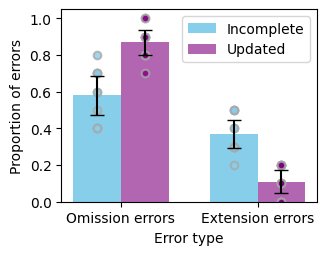

In [75]:
# Function to compare lengths of input and output
def length_comparison(category_data):
    shorter, same, longer = 0, 0, 0
    total_stories = 10  # Each .pkl file has exactly 10 stories in each category
    
    for input_text, output_text in category_data:
        if len(output_text) < len(input_text):
            shorter += 1
        elif len(output_text) == len(input_text):
            same += 1
        else:
            longer += 1
    
    # Ensure we divide by 10 to get fractions (since each .pkl has 10 stories)
    return shorter / total_stories, same / total_stories, longer / total_stories  # Return fractions

# Key remapping dictionary
key_mapping = {
    'typical': 'typical',
    'atypical_short': 'incomplete',
    'atypical_long': 'updated'
}

# Categories to compare
categories = ['incomplete', 'updated']

# Initialize lists to store results for each individual
individual_results = {'incomplete': {'shorter': [], 'longer': []},
                      'updated': {'shorter': [], 'longer': []}}

# Load each .pkl file separately, treating each as an individual
for pkl in glob.glob('plots_new/*.pkl'):
    with open(pkl, 'rb') as f:
        d = pickle.load(f)
    
    # Remap the keys from 'typical', 'atypical_short', 'atypical_long' to 'typical', 'incomplete', 'updated'
    remapped_data = {key_mapping[k]: v for k, v in d.items()}
    
    # Calculate fractions for each category for this individual
    for category in categories:
        shorter, _, longer = length_comparison(remapped_data.get(category, []))
        individual_results[category]['shorter'].append(shorter)
        individual_results[category]['longer'].append(longer)

# Convert individual results to arrays for easier manipulation
incomplete_shorter = np.array(individual_results['incomplete']['shorter'])
incomplete_longer = np.array(individual_results['incomplete']['longer'])
updated_shorter = np.array(individual_results['updated']['shorter'])
updated_longer = np.array(individual_results['updated']['longer'])

# Function to calculate 95% confidence intervals
def calculate_95_ci(data):
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)  # Standard error of the mean
    ci_range = t.ppf(0.975, df=n-1) * sem    # 95% CI (two-tailed, so 0.975 for upper bound)
    return mean, ci_range

# Calculate means and 95% CI for each error type
mean_incomplete_shorter, ci_incomplete_shorter = calculate_95_ci(incomplete_shorter)
mean_incomplete_longer, ci_incomplete_longer = calculate_95_ci(incomplete_longer)
mean_updated_shorter, ci_updated_shorter = calculate_95_ci(updated_shorter)
mean_updated_longer, ci_updated_longer = calculate_95_ci(updated_longer)

means_incomplete = [mean_incomplete_shorter, mean_incomplete_longer]
means_updated = [mean_updated_shorter, mean_updated_longer]

ci_incomplete = [ci_incomplete_shorter, ci_incomplete_longer]
ci_updated = [ci_updated_shorter, ci_updated_longer]

# Prepare data for grouped bar chart
labels = ['Omission errors', 'Extension errors']  # Shorter = Omission, Longer = Extension
x = np.arange(len(labels))  # Label locations
bar_width = 0.35  # Width of bars

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(3.3, 2.5))

# Bars for incomplete (mean with 95% CI error bars)
ax.bar(x - bar_width/2, means_incomplete, bar_width, yerr=ci_incomplete, color='skyblue', alpha=1, label='Incomplete', capsize=5)

# Bars for updated (mean with 95% CI error bars)
ax.bar(x + bar_width/2, means_updated, bar_width, yerr=ci_updated, color='purple', alpha=0.6, label='Updated', capsize=5)

# # Scatter individual data points for incomplete with dark grey circles
# ax.scatter(np.full(len(incomplete_shorter), x[0] - bar_width/2), incomplete_shorter, color='skyblue', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)
# ax.scatter(np.full(len(incomplete_longer), x[1] - bar_width/2), incomplete_longer, color='skyblue', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)

# # Scatter individual data points for updated with dark grey circles
# ax.scatter(np.full(len(updated_shorter), x[0] + bar_width/2), updated_shorter, color='purple', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)
# ax.scatter(np.full(len(updated_longer), x[1] + bar_width/2), updated_longer, color='purple', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)

jitter_amount=0.00
ax.scatter(x[0] - bar_width/2 + np.random.uniform(-jitter_amount, jitter_amount, len(incomplete_shorter)), 
           incomplete_shorter, color='skyblue', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)

ax.scatter(x[1] - bar_width/2 + np.random.uniform(-jitter_amount, jitter_amount, len(incomplete_longer)), 
           incomplete_longer, color='skyblue', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)

# Scatter individual data points for updated with jitter and dark grey circles
ax.scatter(x[0] + bar_width/2 + np.random.uniform(-jitter_amount, jitter_amount, len(updated_shorter)), 
           updated_shorter, color='purple', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)

ax.scatter(x[1] + bar_width/2 + np.random.uniform(-jitter_amount, jitter_amount, len(updated_longer)), 
           updated_longer, color='purple', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)



# Add labels and title
ax.set_xlabel('Error type')
ax.set_ylabel('Proportion of errors')
ax.set_xticks(x)
ax.set_ylim(0, 1.05)
ax.set_xticklabels(labels)
ax.legend()

# Save and show the plot
plt.savefig('omission_vs_extension_with_individuals_95CI.png', bbox_inches='tight', dpi=500)
plt.show()


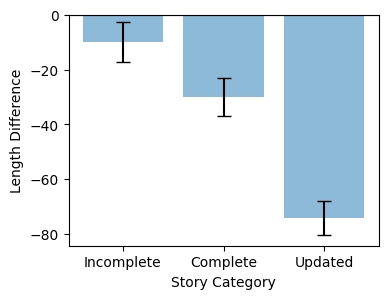

In [79]:
def compute_length_difference_and_sem(stories):
    """
    Computes the length difference and SEM between input and output for a given list of stories.
    """
    differences = []
    for story in stories:
        input_length = len(story[0])
        output_length = len(story[1])
        difference = output_length - input_length
        differences.append(difference)
    average_difference = sum(differences) / len(differences)
    # Calculate SEM
    sem = np.std(differences, ddof=1) / np.sqrt(len(differences))
    return average_difference, sem

combined = {'typical': [], 'atypical_short': [], 'atypical_long': []}
for pkl in glob.glob('plots_new/*.pkl'):
    with open(pkl, 'rb') as f:
        d = pickle.load(f)
    combined['typical'].extend(d['typical'])
    combined['atypical_long'].extend(d['atypical_long'])
    combined['atypical_short'].extend(d['atypical_short'])

# Calculate the average length difference and SEM for each category
typical_difference, typical_sem = compute_length_difference_and_sem(combined['typical'])
atypical_short_difference, atypical_short_sem = compute_length_difference_and_sem(combined['atypical_short'])
atypical_long_difference, atypical_long_sem = compute_length_difference_and_sem(combined['atypical_long'])

# Plotting the results with error bars
categories = ['Incomplete', 'Complete', 'Updated']
differences = [atypical_short_difference, typical_difference, atypical_long_difference]
sems = [atypical_short_sem, typical_sem, atypical_long_sem]  # SEMs for error bars

plt.figure(figsize=(4,3))
plt.bar(categories, differences, yerr=sems, capsize=5, alpha=0.5)  # Add error bars with capsize
plt.xlabel('Story Category')
plt.ylabel('Length Difference')
plt.axhline(y=0, color='black')
plt.savefig('event_ext.png', dpi=500, bbox_inches='tight')
plt.show()
